# CAPSTONE PROJECT: Predicción de ventas de un eCommerce.

**Authors:** Albert García López, Joan Boronat Ruiz, Pep Martí Mascaro

**Date:** 15 de junio de 2021

<font size= "4">**0.1- Nuestro objetivo**</font>

El objetivo final del proceso es ser capaces de predecir las ventas de un e-commerce por producto y fecha.
Para ello, vamos a emplear un modelo de aprendizaje automático, entre varios que testearemos, que sea capaz de tener en cuenta la información contentida en cada registo buscando minimizar la métrica de error empleada en la competición: RMSE, o raíz del error cuadrático medio 
$$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$

El modelo predictivo se va a construir a partir de los datos por producto y dia comprendidos entre el 01/06/2015 y el 30/09/2016.

El modelo generado lo aplicaremos a los datos de un fichero que comprende las fechas entre 01/10/2016 y el 31/12/2016. 

<font size= "4">**0.2- Variables**</font>

**Fecha** : momento del tiempo en el que se produce el evento.
    
**Id**: número identificador del artículo.
    
**Visitas**: número de veces que ha sido visualizada la ficha de un producto dado para un día concreto. Remarcamos que puede darse el caso en el que las visitas sean inferiores a las compras de ese mismo día, siempre que el producto que se ha comprado estuviera previamente añadido al carrito o se haya añadido desde la opción del recomendador sin pasar por ficha de producto.
    
**Categoría_uno**: categoría de producto nivel uno.
    
**Categoría_dos**: segundo nivel de agrupación para cada producto que precede a la de nivel uno.
    
**Estado**: situación en la que se encuentra el producto. Esta variable toma 3 posibles valores para el dataset TRAIN:
- Rotura: no hay stock físico disponible para servir en nuestros almacenes.
- Tránsito: no hay stock físico en nuestros almacenes, pero está pendiente de entrega inminente desde proveedor.
- No Rotura: hay stock físico disponible en nuestros almacenes.

Para el dataset TEST todas las variables aparecen con el estado Tránsito o No Rotura.

**Precio**: indica el precio unitario al que se realiza la transacción. Cuando su valor es nulo, ha de ser completado con el precio anterior temporalmente más cercano para cada artículo.

**Día atípico**: toma los siguientes valores:
- 0: si estamos fuera de fechas con comportamiento atípico.
- 1: si estamos en un periodo con una demanda más alta de lo habitual.
- -1: si estamos en un periodo con una demanda más baja de lo habitual.

**Campaña**: esta variable nos indica para las campañas principales, si el producto estaba en promoción o no en una fecha determinada.

**Antigüedad**: días transcurridos desde la entrada en catálogo de cada producto.

**Unidades vendidas**: variable a predecir. Nos indica las unidades vendidas para cada día y cada artículo.

### Referencias

* https://stackoverflow.com/questions/50565937/how-to-normalize-the-train-and-test-data-using-minmaxscaler-sklearn/50567308
* https://facebook.github.io/prophet/docs/quick_start.html#python-api
* https://www.kaggle.com/elenapetrova/time-series-analysis-and-forecasts-with-prophet
* https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-choosing-recipes.html
* https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
* https://towardsdatascience.com/demand-forecasting-using-fb-prophet-e3d1444b9dd8
* https://www.tensorflow.org/tutorials/structured_data/time_series
* https://nbviewer.jupyter.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb
* https://machinelearningmastery.com/blending-ensemble-machine-learning-with-python/

### Table of contents

1. [Carga de datos y librerías relevantes](#Libraries)
2. [Data Preprocess](#Preprocess)
3. [Análisis exploratorio de los datos](#explorandoDatos)
4. [Modelos probados y no utilizados](#Modelos)
    1. [Modelo básico basado en las ventas del año anterior y la tendencia de los datos](#ModeloAñoAnterior)
    1. [Modelo lineal Ridge para agrupaciones por categorías](#ModeloRidge)

<br><br>

# <a name="Libraries"> 1. Carga de datos y librerías relevantes:
A lo largo del proyecto emplearemos diversas librerías de Python que nos ayudarán en cada fase del proceso. A continuación, detallamos las que vamos a emplear:
- **Datetime:** Por la naturaleza fechada de los conjuntos de datos a emplear, esta librería nos permite manejar la característica fecha y generar nuevas características a partir de ella.
- **Matplotlib:** Para generar visualizaciones a lo largo del análisis inicial de los datos y, posteriormente, durante la validación de los modelos testados.
- **Numpy:** Emplearemos Numpy en la definición de funciones para calcular las métricas asi como para dar forma a las matrices de datos que vamos a emplear en la alimentación de los modelos.
- **Pandas:** Librería más utilizada durante el proyecto, nos permite manejar de forma sencilla las tablas de datos, generar consultas en base a niveles específicos de las características de los conjuntos de datos y agilizar el feature engineering.
- **Seaborn:** Nos permite generar visualizaciones sencillas de los datos de forma más ágil que Matplotlib.
- **Math:** Nos da acceso a diferentes funciones matemáticas.
- **SkLearn:** Paquete principal de modelaje de datos, nos va a proporcionar algunos de los modelos que vamos a emplear y metodos para escalar/estandarizar nuestros datos.
- **Tqdm:** Nos permite controlar el progreso de los procesos iterativos a emplear.
- **XGBoost:** Uno de los modelos de predicción principales que vamos a emplear para cumplir el objetivo del proyecto.
- **Fbprophet:** Otro de los modelos de predicción principales a utilizar.
- **Statistics:** Nos proporciona una serie de métodos para obtener los descriptivos de nuestros datos.
- **Missigno:** Utilizaremos Missigno para ver de forma gráfica dónde están los valores indisponibles en nuestros conjuntos de datos.
- **Plotly:** Graficación interactiva para la visualización del problema.
- **Pickle:** Para la persistencia de nuestros datos.

In [ ]:
import datetime as dt
from datetime import date,timedelta

import matplotlib.pylab as plt
import seaborn as sns

import numpy as np
import pandas as pd

import math

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from tqdm.notebook import tqdm

import xgboost as xgb

import statistics

import missingno as msno

import plotly.express as px
import plotly.graph_objects as go

from fbprophet import Prophet

import pickle

%matplotlib inline
plt.style.use('./base.mplstyle')

Guardamos nuestros conjuntos de datos en sendas variables en forma de DataFrame

In [ ]:
df_test = pd.read_csv('Estimar2.txt', sep='|', low_memory=False)
df_test['fecha'] = pd.to_datetime(df_test['fecha'], format='%Y-%m-%d')

In [ ]:
raw_df = pd.read_csv('Modelar_UH2021.txt', sep='|')
df = raw_df.copy()

df['fecha'] = pd.to_datetime(raw_df['fecha'].str.split(' ').str[0], format='%d/%m/%Y')
days_count = (df['fecha'].max() - df['fecha'].min()).days
days_count_test = (df_test['fecha'].max() - df_test['fecha'].min()).days

## 2.0 Primer vistazo a nuestros datos:

##### 2.1: Datos duplicados:
Observamos que en nuestro conjunto de modelado existen registros que son prácticamente idénticos, cuya única diferencia se encuentra en los milisegundos del timestamp. Estos registros agregarán confusión en el modelo por lo que procederemos a eliminarlos durante el preprocesado y quedarnos con los registros únicos.

In [ ]:
print('-----------Training set------------')
print(f"El training set esta compuesto por {df.shape[0]} registros (filas) de {df.shape[1]} variables.")
print(f"Les fechas van desde {df['fecha'].min()} a {df['fecha'].max()}.")
print(f"Esperamos tener {days_count} registros por producto.")
print(f"Existen {df.duplicated().sum()} registros duplicados.")
print(f"Existen {df['id'].nunique()} productos unicos.")
print(f"Existen {df['categoria_uno'].nunique()} categoria_uno unicas.")
print(f"Existen {df['categoria_dos'].nunique()} categoria_dos unicas.\n")

-----------Training set------------
El training set esta compuesto por 4045022 registros (filas) de 11 variables.
Les fechas van desde 2015-06-01 00:00:00 a 2016-09-30 00:00:00.
Esperamos tener 487 registros por producto.
Existen 2004985 registros duplicados.
Existen 4168 productos unicos.
Existen 13 categoria_uno unicas.
Existen 182 categoria_dos unicas.



In [ ]:
df_ns = df.copy()
df_ns['time'] = pd.to_timedelta(df_ns.groupby('fecha').cumcount(), unit='ms')
df_dups = df.duplicated()
print("Numero de registros identicos a excepción de los milisegundos del timestamp:", len(df_dups[df_dups == True]))

Numero de registros identicos a excepción de los milisegundos del timestamp: 2004985


##### 2.2: Datos indisponibles:
Encontramos valores indisponibles en Precio, Antigüedad y Categoría_Dos que posteriormente trataremos durante el preprocesado:
- **Precio:** En la explicación sobre el proyecto se nos proporciona el método para remplazar estos valores indisponibles
- **Antigüedad:** Tenemos un número relativamente alto de valores indisponibles en esta característica que podremos estimar fácilmente durante el preprocesado mediante un KNearestNeighbors ya que, durante el análisis exploratorio veremos que esta variable correlaciona fuertemente con otras, principalmente con el id (lo que nos indica que las id de cada producto se han ido a asignando de forma ascendente a medida que se han introducido nuevos productos en la web)
- **Categoría_Dos:** En número de valores indisponibles es muy reducido y vamos a utilizar modelos capaces de gestionar la presencia de algunos de ellos por lo que no se va a aplicar un método para rellenarlos

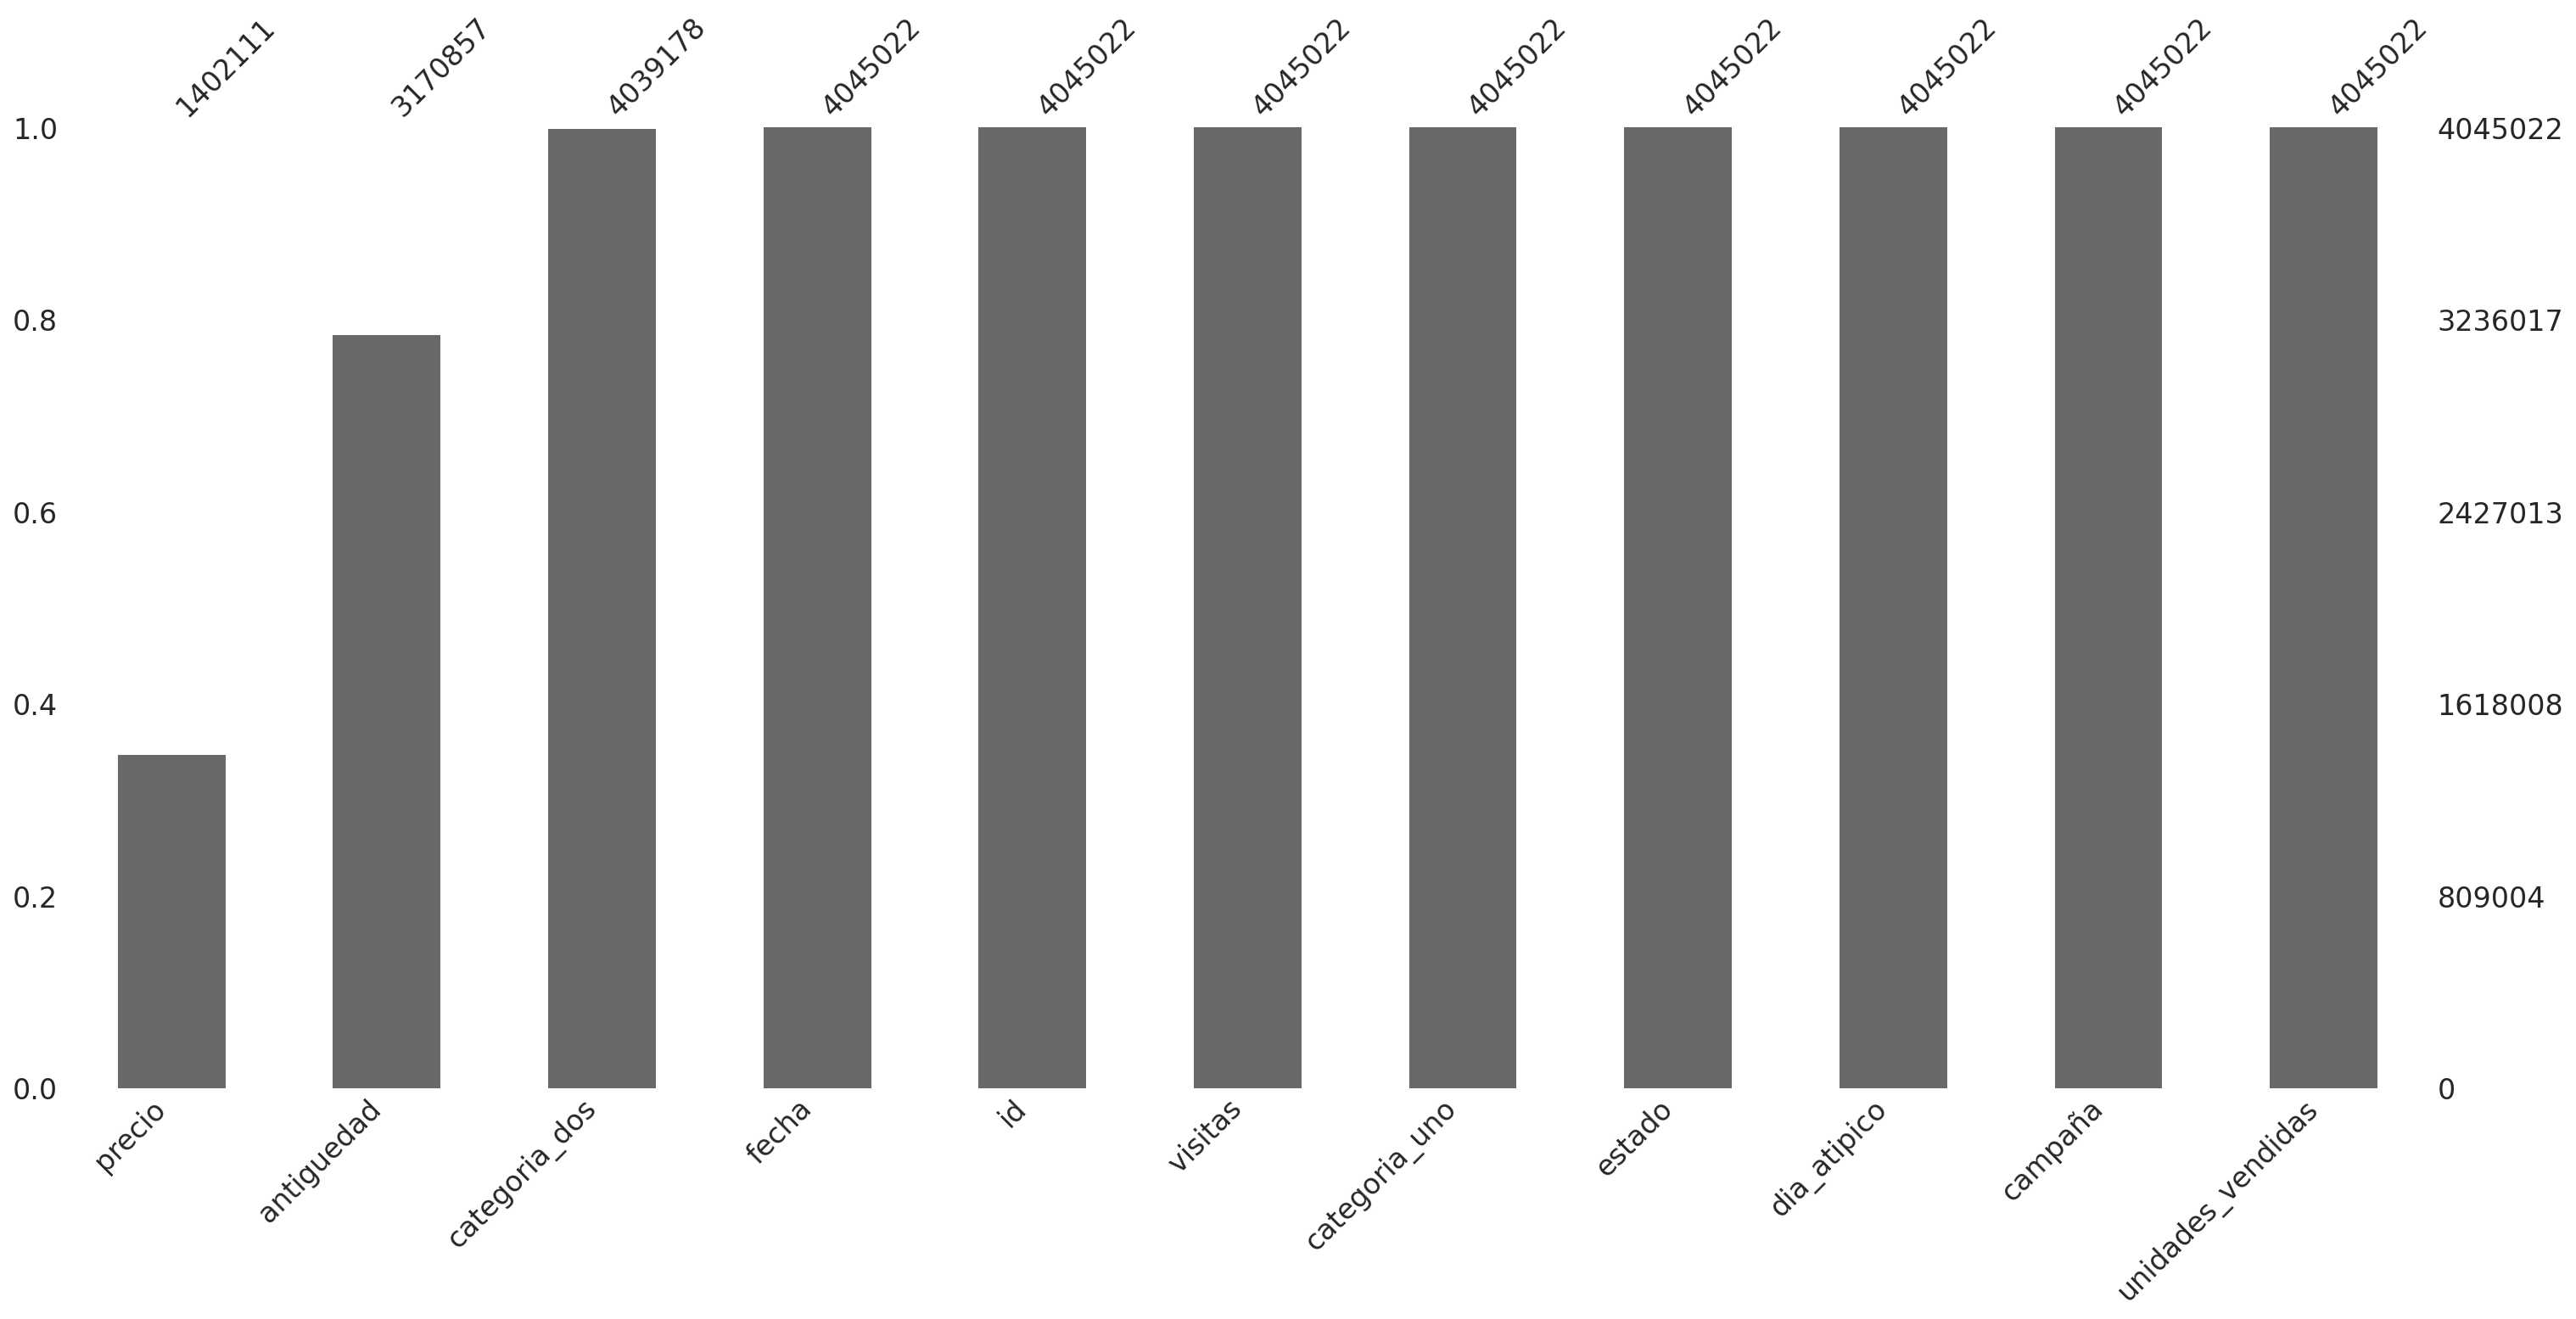

In [ ]:
msno.bar(df, sort='ascending')

## 3.0 Visualizando el Problema:

##### 3.1 Evolución variable objetivo: Unidades Vendidas.
Observamos, a partir de una visualización, el comportamiento temporal de la variable a predecir y dos componentes clave:
- **Estacionalidad Semanal**: El día de la semana es un factor clave a la hora de estimar el número de ventas que se van a realizar a través de la web.

- **Periodos Clave**: En los periodos sombreados en verde, que corresponden a días atípicos con demanda superior a la habitual, se producen picos de demanda. Estos periodos se corresponden a momentos clave durante el año: Navidades, Happy Days y Black Friday. Por otra parte, los periodos sombreados en rojo se corresponden con los días atípicos con demanda inferior a la habitual. Por ejemplo, festividades nacionales o dia de Navidad.

- Por este motivo, durante el preprocesado extraeremos, de la variable fecha, el mes y el día de la semana de cada registro y generaremos con ellos nuevas características.


In [ ]:
min_test_date = df_test['fecha'].min().strftime('%Y-%m-%d')
max_test_date = df_test['fecha'].max().strftime('%Y-%m-%d')
min_train_date = df['fecha'].min().strftime('%Y-%m-%d')
max_train_date = df['fecha'].max().strftime('%Y-%m-%d')

print(f"We will have to predict the sales from {min_test_date} to {max_test_date}")
print(f"With data registers that range from from {min_train_date} to {max_train_date}")

We will have to predict the sales from 2016-10-01 to 2016-12-31
With data registers that range from from 2015-06-01 to 2016-09-30


In [ ]:
holidays_train = df[['fecha', 'dia_atipico']]
holidays_test = df_test[['fecha', 'dia_atipico']]
holidays = pd.concat([holidays_train, holidays_test])

holidays.drop_duplicates(inplace=True)
holidays = holidays[holidays['dia_atipico'] != 0]

holidays.loc[holidays['dia_atipico'] == 1, 'holiday'] = 'positive'
holidays.loc[holidays['dia_atipico'] == -1, 'holiday'] = 'negative'

In [ ]:
def plot(train, kpi, test=None, holidays=None, agg=None):

    fig, ax = plt.subplots(figsize=(15,4))

    _ = train.plot(ax=ax, y=kpi, lw=.8)
    labels = [f'Train {kpi}{agg}' if agg else f'Train {kpi}']
    if test is not None:
        labels.append(f'Test {kpi}')
        _ = test.plot(ax=ax, y=kpi, lw=.8)
    
    ax.legend(
        labels,
        ncol=3,
        bbox_to_anchor=(0.5, 1.15),
        prop={'size': 12},
        frameon=False
    )
    
    if holidays is not None:
        for holiday in holidays.to_dict('records'):
            if holiday['dia_atipico'] == 1:
                plt.axvline(x=holiday['fecha'], alpha=.1, color='green')
            elif holiday['dia_atipico'] == -1:
                plt.axvline(x=holiday['fecha'], alpha=.1, color='red')

    _ = ax.set_xlabel('')

In [ ]:
train_uds = df.groupby(['fecha']).sum().fillna(0)

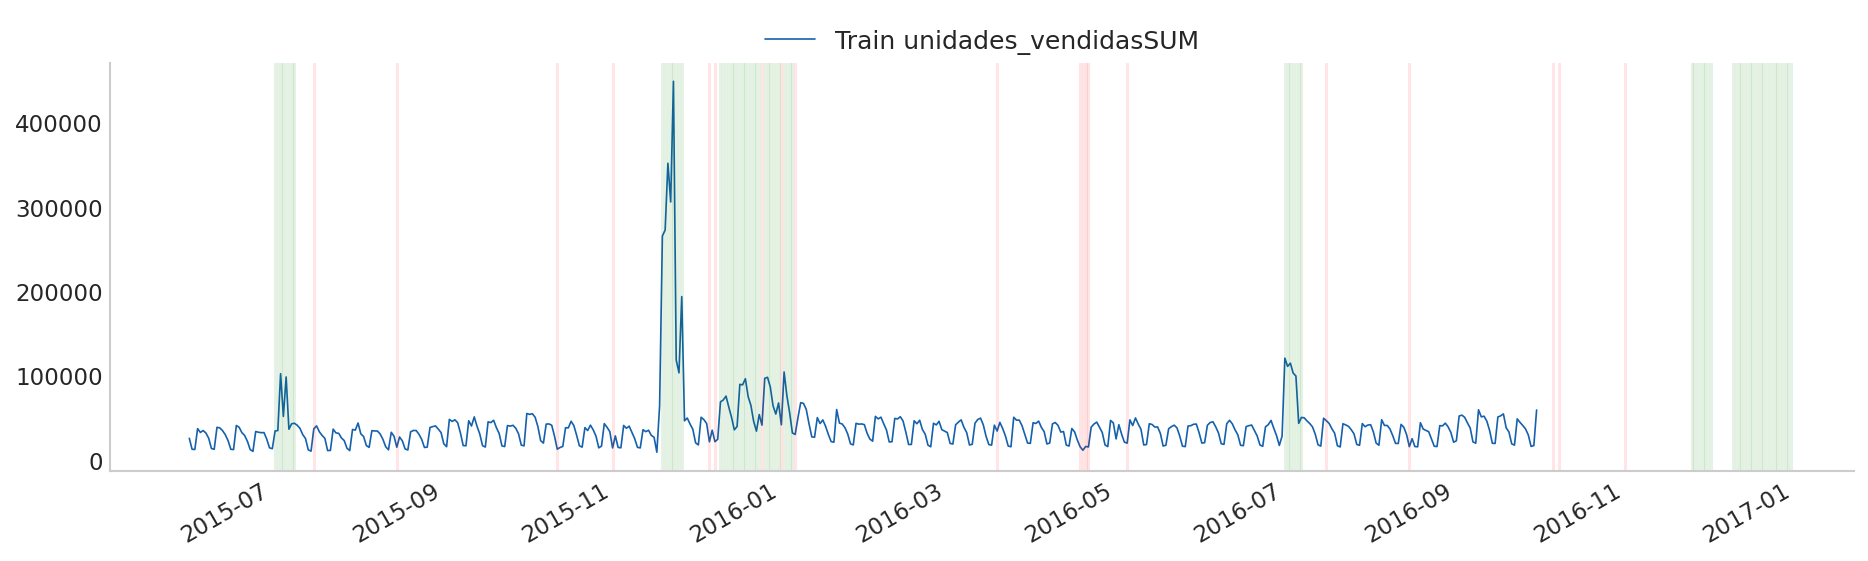

In [ ]:
plot(train_uds, 'unidades_vendidas', holidays=holidays, agg='SUM')

##### 3.2: Offset en las visitas:
A partir del primer vistazo a los datos observamos que, a partir del 25 de enero de 2016, las visitas se contabilizan de forma distinta. Indagando en profundidad en la diferencia, observamos que, mientras durante el primer periodo las visitas se contabilizan de 1 en 1, a partir del segundo periodo, se hacen de 5 en 5. Durante el preprocesado de los datos, se va a aplicar un factor x5 a la variable visitas para todos los registros anteriores al 25 de enero de 2016.

###### 3.2.1: Visualización de las visitas en el conjunto de datos:

In [ ]:
test = df_test.groupby(['fecha']).mean().fillna(0)
train = df.groupby(['fecha']).mean().fillna(0)

train['fecha_col'] = train.index.get_level_values('fecha')
test['fecha_col'] = test.index.get_level_values('fecha')

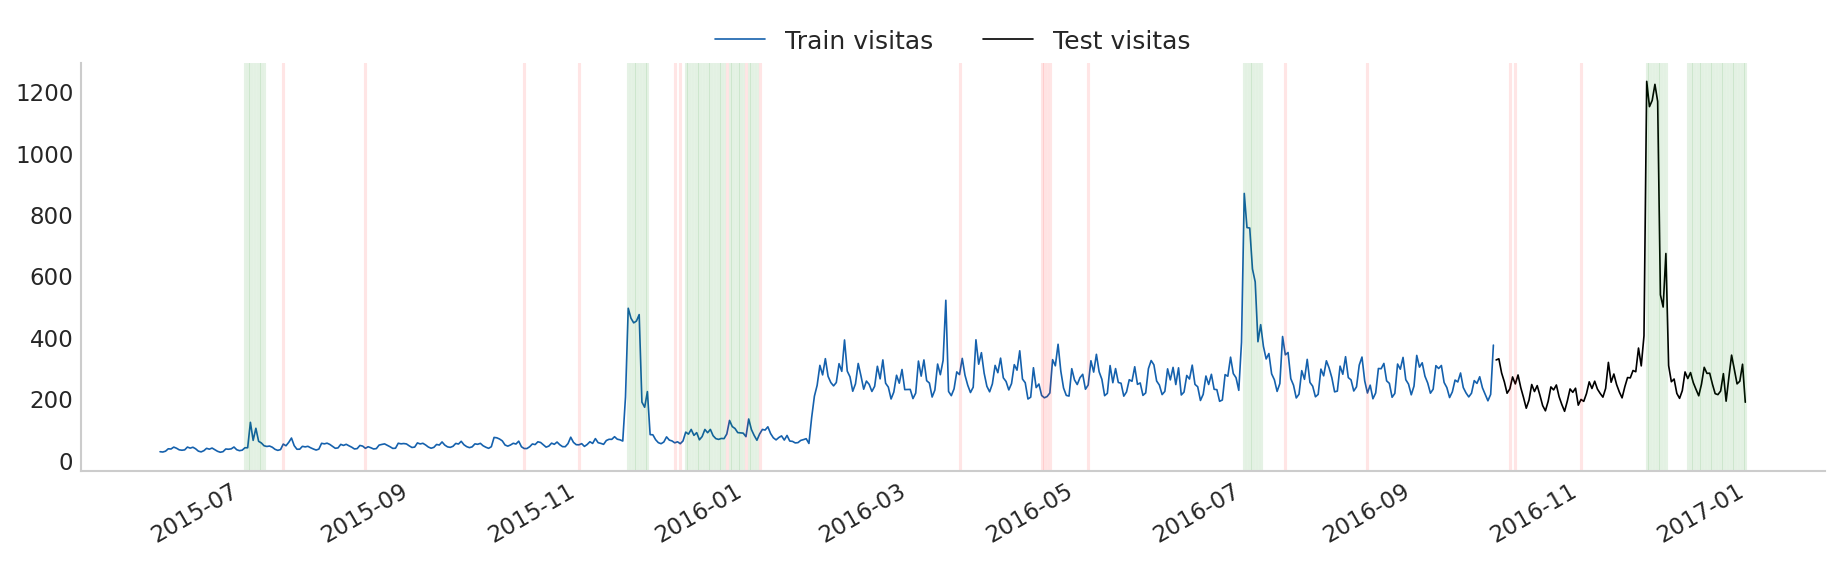

In [ ]:
plot(train, 'visitas', test, holidays)

###### 3.2.2: Registros de visitas antes y despues del 25-Ene-2016:

In [ ]:
before = sorted(set(df[df['fecha'] < '2016-01-25'].visitas))
after = sorted(set(df[df['fecha'] >= '2016-01-25'].visitas))
print(f'Values before Jan25\'16 {before[:20]}')
print(f'Values after Jan25\'16 {after[:20]}')

Values before Jan25'16 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Values after Jan25'16 [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]


##### 3.3: Visualización interactiva de la relación entre visitas y ventas:

<div class = "alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
    
**Importante**: 
<ol>

Es necesario tener instalado el paquete Plotly para la visualización del siguiente gráfico.

</ol>
</div>


In [ ]:
test = df_test.groupby(['fecha']).sum().fillna(0)
train = df.groupby(['fecha']).sum().fillna(0)

train['fecha_col'] = train.index.get_level_values('fecha')
test['fecha_col'] = test.index.get_level_values('fecha')

In [ ]:
low_dmd = []
for item in set(df[df.dia_atipico == -1]['fecha']):
    low_dmd.append(item)

high_dmd = []
for item in set(df[df.dia_atipico == 1]['fecha']):
    high_dmd.append(item)
    
dates_low_dmd = [item.strftime("%Y-%m-%d")for item in low_dmd]
dates_high_dmd = [item.strftime("%Y-%m-%d")for item in high_dmd]

campaña = []
for item in set(df[df.campaña == 1]['fecha']):
    campaña.append(item)
campaña.sort()

# Add rectangles
def campaña_vxline(campaña):
    i = 0
    dates = []
    while campaña[i] < campaña[-1]:
        aux1 = campaña[i]
        aux2 = campaña[i+1]    
        diff = (aux2-aux1).days # check if the difference is 1
        j=i+1

        dates.append( campaña[i]) # used to get the x0 axis of the rectangle
    
        first_date_campaña = campaña[i] # get first date of the campaña
        while diff == 1 and campaña[j] < campaña[-1]: # we are into one particular sale

            aux1 = campaña[j]
            aux2 = campaña[j+1] 
            diff = (aux2-aux1).days
            if diff > 1: 
                dates.append( campaña[j] )
            j += 1
            if campaña[j] == campaña[-1]: 
                dates.append( campaña[j]) 
        i = j  
    return dates
dates = campaña_vxline(campaña)

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=train['fecha_col'],y=train['unidades_vendidas'], mode='lines',connectgaps=True,name='unidades vendidas')
)
fig.add_trace(
    go.Scatter(x=train['fecha_col'],y=train['visitas'], mode='lines',connectgaps=True,name='visitas')
)

fig.update_layout(
    plot_bgcolor='white',width=1000,
    height=400,
    yaxis=dict(
    showgrid=True,
    ))

# add lines using absolute references
for k in set(high_dmd):
    fig.add_shape(type='line',
               yref="y",
                xref="x",
                x0=k,
                y0=train['unidades_vendidas'].min()*1,
                x1=k,
                y1=train['visitas'].max()*1.2,
                line=dict(color='aquamarine', width=1.5),
                opacity=0.5)
    
# add lines using absolute references
for k in set(low_dmd):
    fig.add_shape(type='line',
                yref="y",
                xref="x",
                x0=k,
                y0=train['unidades_vendidas'].min()*1,
                x1=k,
                y1=train['visitas'].max()*1.2,
                line=dict(color='orange', width=1.5),
                opacity=0.5)
    
# Add rectangles
for k in range( len(dates)-1 ):
    if k % 2 == 0: 
        aux = dates[k+1]
        j = aux
        fig.add_vrect(
            x0=dates[k],
            #y0=train['unidades_vendidas'].min()*1.2,
            x1=dates[k+1],
            #y1=train['unidades_vendidas'].max()*1.2,
            fillcolor="red", opacity=0.2,
            layer="below", line_width=0,
    )
fig.show()

<br><br>
## 1.2 Descripción de los datos

Para empezar, vamos a resumir brevemente las caracteristicas generales de nuestro train y test set:

In [ ]:
# computing the percentage of duplicated rows
prop_duplicated_rows = (df.duplicated().sum()*100)/df.shape[0]

print('-----------Training set------------')
print(f"El training set esta compuesto por {df.shape[0]} registros (filas) de {df.shape[1]} variables.")
print(f"Les fechas van desde {df['fecha'].min().strftime('%Y-%m-%d')} a {df['fecha'].max().strftime('%Y-%m-%d')}.")
print(f"Esperamos tener {days_count} registros por producto.")
print("Existen", df.duplicated().sum()," registros duplicados. Esto es, el %.2f" % prop_duplicated_rows, "% de las columnas estan duplicadas.")
print(f"Existen {df['id'].nunique()} productos unicos.")
print(f"Existen {df['categoria_uno'].nunique()} categoria_uno unicas.")
print(f"Existen {df['categoria_dos'].nunique()} categoria_dos unicas.\n")

print('-----------Test set------------')
print(f"El test set esta compuesto por {df_test.shape[0]} registros (filas) de {df_test.shape[1]} variables.")
print(f"Les fechas van desde {df_test['fecha'].min().strftime('%Y-%m-%d')} a {df_test['fecha'].max().strftime('%Y-%m-%d')}.")
print(f"Esperamos tener {days_count_test} registros por producto.")
print(f"Existen {df_test.duplicated().sum()} registros duplicados.")
print(f"Existen {df_test['id'].nunique()} productos unicos.")
print(f"Existen {df_test['categoria_uno'].nunique()} categoria_uno unicas.")
print(f"Existen {df_test['categoria_dos'].nunique()} categoria_dos unicas.")

-----------Training set------------
El training set esta compuesto por 4045022 registros (filas) de 11 variables.
Les fechas van desde 2015-06-01 a 2016-09-30.
Esperamos tener 487 registros por producto.
Existen 2004985  registros duplicados. Esto es, el 49.57 % de las columnas estan duplicadas.
Existen 4168 productos unicos.
Existen 13 categoria_uno unicas.
Existen 182 categoria_dos unicas.

-----------Test set------------
El test set esta compuesto por 212841 registros (filas) de 10 variables.
Les fechas van desde 2016-10-01 a 2016-12-31.
Esperamos tener 91 registros por producto.
Existen 0 registros duplicados.
Existen 2736 productos unicos.
Existen 13 categoria_uno unicas.
Existen 164 categoria_dos unicas.


**Observaciones**
- El conjunto de modelaje (training set) contiene una variable más que el conjunto predictivo (test set) ya que el primero incluye la variable a predecir.

- El training set contiene un 49,57% de filas duplicadas mientras que el test set no contiene duplicados.

- El training set contiene 4168 productos distintos mientras que en test solo tenemos 2736 productos distintos.

- También se observa como el número de categoria_dos es menor para el test set que para el training set.

<br>
Para trabajar con datos es muy importante entender como estan estructurados. Por este motivo, siempre es conveniente echar un vistazo a las primeras y a las ultimas filas del conjunto de datos. En este caso hemos escogido el conjunto de modelado.

In [ ]:
display(df.head(2))
df.tail(2)

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,2015-06-01,21972,0,C,75.0,No Rotura,NaN,0,0,5241.0,0
1,2015-06-01,23910,5,C,170.0,No Rotura,"6,07",0,0,5241.0,3


,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
4045020,2016-09-30,458660,1915,K,340.0,No Rotura,"68,49",0,0,126.0,24
4045021,2016-09-30,458660,1915,K,340.0,No Rotura,"68,49",0,0,126.0,24


**Observaciones**

- Podemos ver como ya en la primera fila tenemos NaN de precio, estos valores tendran que ser rellenados así como se solicita en la pagina web del reto. Esto es, cuando su valor es nulo, el precio debe ser completado con el precio anterior temporalmente más cercano para cada artículo.

- También referente a precio, en secciones posteriores tendremos que modificarem el delimitador decimal, para que este sea un punto en vez de una coma. 

- Algunas variables categoricas como categoria_dos, dia_atipico y campaña tienen valores numericos. En secciones posteriores corregiremos este detalle para que sean tratadas como variables categoricas.

<br><br>

# <a name="Preprocess"> 2. Preprocesado <a class="anchor" id="chapter1"></a>
### 2.1 Quitar duplicados

Hemos observado que alrededor de un 50% de las filas del conjunto de modelaje estan duplicadas. Si agregamos los datos por producto, podemos ver como 1199 productos de los 4168 tienen más registros que días y estos deberian ser iguales. 

In [ ]:
def count_duplicates(df):
    g = df.groupby('id').size()
    return g[g != days_count].shape[0]

count = count_duplicates(df)
print(f"There are {count} products with more registers than days.")

There are 1392 products with more registers than days.


Los registros que aparecen completamente duplicados los vamos a eliminar:

In [ ]:
df = df[~df.duplicated()]

<br>
Una vez los duplicados han sido eliminados. Miremos si quedan productos en que el número de registros difiere del número de días en que se tiene datos para estos productos.

In [ ]:
count = count_duplicates(df)
print(f"There are {count} products with more registers than days.")

There are 1199 products with more registers than days.


 Estudiemos el primer caso en que esto ocurre:

In [ ]:
g = df.groupby('id').size()
example_id = g[g != days_count].reset_index()['id'].values[0]
df_example = df[df['id'] == example_id]
df_example[df_example.duplicated(subset=['fecha'], keep=False)].head(5)

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
290712,2015-07-06,24306,409,A,46.0,No Rotura,"7,04",1,1,NaN,15
290713,2015-07-06,24306,409,A,46.0,No Rotura,"7,04",1,0,NaN,15
299018,2015-07-07,24306,223,A,46.0,No Rotura,"6,77",1,0,NaN,3
299019,2015-07-07,24306,223,A,46.0,No Rotura,"6,77",1,1,NaN,3
307324,2015-07-08,24306,128,A,46.0,No Rotura,"6,77",1,1,NaN,27


La diferencia entre estos duplicados es la campaña. Vamos a quedarnos con los productos con el valor de campaña igual 0 si hay registros en el mismo dia con el valor de campaña igual a 1.

In [ ]:
columns = df.columns.tolist()
columns.remove('campaña')

df.loc[df.duplicated(columns, keep=False), 'campaña'] = '1'
df = df[~df.duplicated()]

In [ ]:
count = count_duplicates(df)
print(f"There are still {count} products with more registers than days.")

There are still 3 products with more registers than days.


Vamos a eliminar esto tres productos a que si los analizamos podemos ver que cuando rellenemos los valors que faltan de antiguedad estos se convertiran en registros completamente duplicados. 

In [ ]:
g = df.groupby('id').size()
example_id = g[g != days_count].reset_index()['id'].sample().values[0]
df_example = df[df['id'] == example_id]
df_example[df_example.duplicated(subset=['fecha'], keep=False)].head(5)

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
7582,2015-06-01,360016,0,A,46.0,No Rotura,NaN,0,0,NaN,0
7584,2015-06-01,360016,0,A,46.0,No Rotura,NaN,0,0,372.0,0
15888,2015-06-02,360016,0,A,46.0,No Rotura,NaN,0,0,372.0,0
15890,2015-06-02,360016,0,A,46.0,No Rotura,NaN,0,0,NaN,0
24194,2015-06-03,360016,0,A,46.0,No Rotura,NaN,0,0,372.0,0



### 2.2 Redefinir los tipos de variables

Como avanzamos en la sección en que se describieron los datos, vamos a redefinir el tipo de variable de nuestras variables de la siguiente manera:
- **precio:** Cambiar separador decimal, puntos por comas. Luego, lo convertimos a float.
- **id, categoria_dos, dia_atipico, campaña:** Estas variables son variables categoricas que estaban definidos como números enteros, los pasamos a string.

In [ ]:
df['precio'] = df['precio'].str.replace(',', '.')
df_test['precio'] = df_test['precio'].str.replace(',', '.')

dtypes = {
    'id': str,
    'categoria_dos': str,
    'precio': float,
    'dia_atipico': str,
    'campaña': str,
}

df = df.astype(dtypes)

df_test = df_test.replace('-', 0).astype(dtypes)
df_test = df_test.astype(dtypes)

### 2.3 Estimar los datos que faltan

Tenemos alrededor de un 20% de valores de antigüedad con valores nulos. 

Para rellenar dichos valores hemos elegido estimar la antigüedad aplicando el algoritmo de clasificación K-nearest neighbors (K vecinos más próximos) a partir características que hemos observado que guardan relación con la antigüedad. En este caso en particular nos hemos decidido por utilizar un valor de k igual a 3.

In [ ]:
def estimate_antiquity(X_train, X_test):

    y_train = X_train['antiguedad']
    y_test = X_test['antiguedad']

    X_train['id_feature'] = X_train['id']
    X_test['id_feature'] = X_test['id']

    features = ['visitas', 'id_feature', 'precio', 'unidades_vendidas']

    for feature in features:
        scaler = MinMaxScaler()
        X_train[feature] = scaler.fit_transform(X_train[[feature]])
        X_test[feature] = scaler.transform(X_test[[feature]])

    columns = ['categoria_uno', 'categoria_dos']
    X_train = X_train[['id'] + columns + features]
    X_train = pd.get_dummies(X_train, columns=columns)

    X_test = X_test[['id'] + columns + features]
    X_test = pd.get_dummies(X_test, columns=columns)

    classifier = KNeighborsClassifier(n_neighbors=3)
    classifier.fit(X_train, y_train)

    for col in X_train.columns:
        if col not in X_test:
            X_test[col] = 0

    for col in X_test.columns:
        if col not in X_train:
            X_test.drop(columns=[col], inplace=True)

    return classifier.predict(X_test)

In [ ]:
X_train = df[~df.antiguedad.isna()].groupby(['id', 'categoria_uno', 'categoria_dos']).min()
X_train = X_train.reset_index()

X_test = df[df.antiguedad.isna()].groupby(['id', 'categoria_uno', 'categoria_dos']).min()
X_test = X_test.reset_index()

X_test['antiguedad'] = estimate_antiquity(X_train, X_test)

data_by_product = []
antiguedad_estimated = X_test[['id', 'antiguedad']].set_index('id').T.to_dict()

<br><br>
### 2.4 Rellenar los datos que faltan

**Rellenando valores nulos de _precio_:** Siguiendo el enunciado del problema, cuando el valor de _precio_ es nulo, este será completado con el precio anterior temporalmente más cercano para cada artículo. 

Al final de este proceso hemos visto que aun existen algunos valores nulos, estos serán rellenados con el valor posterior temporalmente más cercano.

**Rellenando valores nulos de _antiguedad_:** Utilizaremos la función creada en la sección anterior para rellenar los nulos corresponientes a antigüedad

In [ ]:
def fill_missing_values(df, label, antiguedad_estimated):
    
    data_by_product = []
    for product_id in tqdm(set(df['id']), desc=f'Cleaning {label}'):

        aux = df[df['id'] == product_id]
        aux = aux[~aux.duplicated()]
        # Fill the price with the previous most recent value. (Forward fill)
        aux['precio'].ffill(inplace=True)
        aux['antiguedad'].ffill(inplace=True)
        # There are still some missing values. Fill with most recent value. (Back fill)
        aux['precio'].bfill(inplace=True)
        aux['antiguedad'].bfill(inplace=True)
        
        data_by_product.append(aux)

    return pd.concat(data_by_product)

In [ ]:
df = fill_missing_values(df, 'train', antiguedad_estimated)
df_test = fill_missing_values(df_test, 'test', antiguedad_estimated)

In [ ]:
columns = ['fecha', 'id', 'visitas', 'categoria_uno', 'categoria_dos', 
           'estado', 'precio', 'dia_atipico', 'campaña', 'unidades_vendidas']

df = df[~df.duplicated(subset=columns)]
g = df.groupby('id').size()

count = g[g != days_count].shape[0]
print(f"After some cleaning, we have {count} products with more registers than days.")

After some cleaning, we have 0 products with more registers than days.


### 2.5 Normalizar las visitas

Como ya hemos podido observar en secciones anteriores, el número de visitas a la página web daba un salto significativo el 25 de enero de 2016. 

Tras investigar diferentes opciones, nos dimos cuenta de que el factor clave es que las visitas antes del 25 de enero de 2016 se contaban de una en una, mientras que después se contaron de cinco en cinco:

In [ ]:
before = sorted(set(df[df['fecha'] < '2016-01-25'].visitas))
after = sorted(set(df[df['fecha'] >= '2016-01-25'].visitas))
print(f'Values before Jan25\'16 {before[:20]}')
print(f'Values after Jan25\'16 {after[:20]}')

Values before Jan25'16 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Values after Jan25'16 [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]


Una explicación puede ser que hubo una actualización de la pagina web, por lo que decidimos multiplicar por 5 todas las visitas previas a la fecha 25 de enero del 2016, sin embargo, puede haber otros muchos significados a esta alteración en visitas.

In [ ]:
print("---Offset in visitas, option that multiplies by 5 visitas before 25jan16---\n")
df['visitas_normalized2'] = df['visitas']
df_test['visitas_normalized2'] = df_test['visitas']

mask = df['fecha'] < '2016-01-25'
df.loc[mask, 'visitas_normalized2'] = df.loc[mask, 'visitas'] * 5
print("mean train before 25jan16: ", df[mask]['visitas_normalized2'].mean())
print("median train before 25jan16: ", df[mask]['visitas_normalized2'].median(),"\n")

mask = df['fecha'] >= '2016-01-25'
print("mean train after 25jan16: ", df[mask]['visitas_normalized2'].mean() )
print("median train after 25jan16: ", df[mask]['visitas_normalized2'].median(),"\n" )

print("mean test: ", df_test['visitas_normalized2'].mean() )
print("median test: ", df_test['visitas_normalized2'].median() )

---Offset in visitas, option that multiplies by 5 visitas before 25jan16---

mean train before 25jan16:  218.744158171906
median train before 25jan16:  50.0 

mean train after 25jan16:  191.83776854057305
median train after 25jan16:  50.0 

mean test:  305.879623756701
median test:  75.0


In [ ]:
test = df_test.groupby(['fecha']).mean().fillna(0)
train = df.groupby(['fecha']).mean().fillna(0)

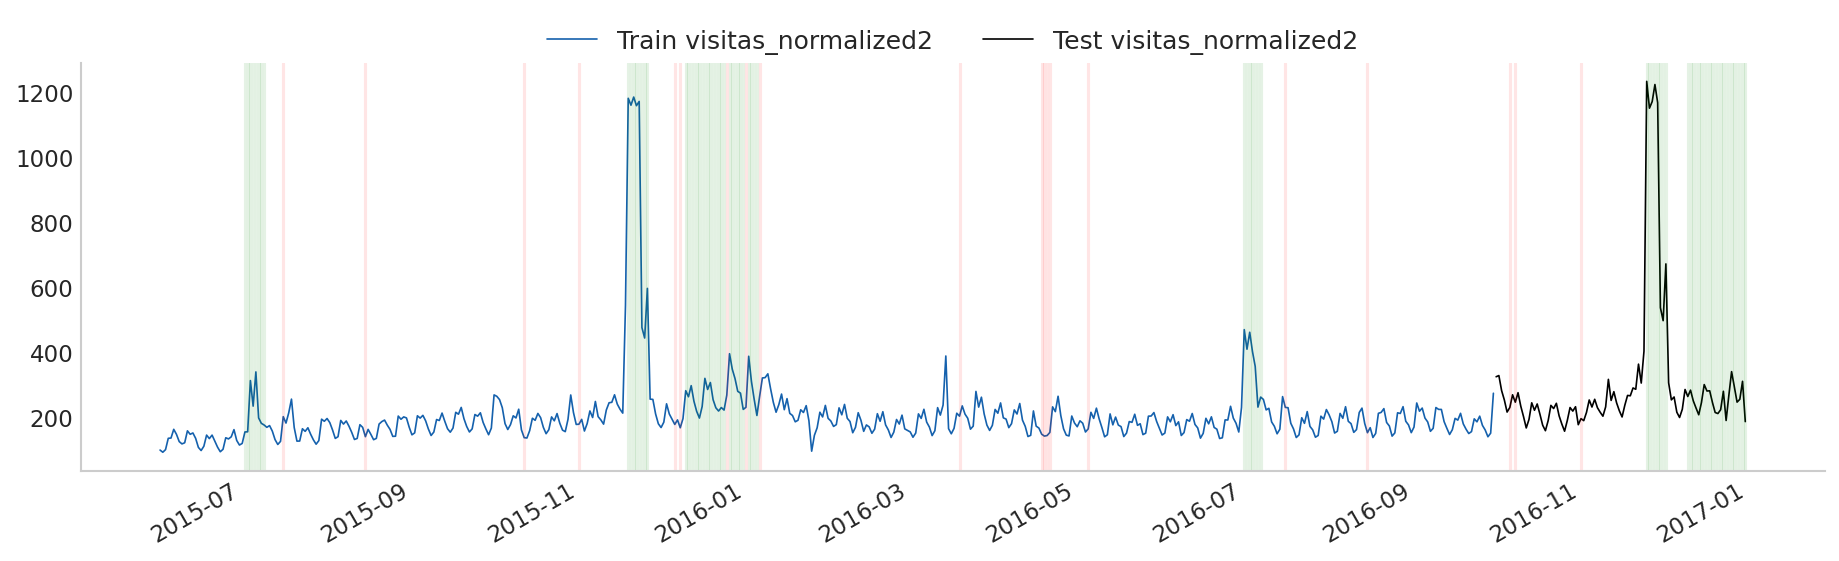

In [ ]:
plot(train, 'visitas_normalized2', test, holidays)

#### 2.5 Normalizar las visitas - Idea inicial no utilizada

Antes de dar con la solución explicada arriba habíamos escogido una estrategia diferente para las visitas. Nuestra decisión fue normalizar las visitas de antes del 25 de enero del 2016 por el ratio de la media del segundo periodo y la media del primer periodo. Este valor multiplicaba las visitas pre 25 de enero por 4.38.

In [ ]:
###
print("---Offset in visitas, option that applies mean second period divided by mean 1st period to 1st period---\n")
df['visitas_normalized'] = df['visitas']
df_test['visitas_normalized'] = df_test['visitas']

mask = df['fecha'] >= '2016-01-25'
second_period_mean = df[mask]['visitas'].mean()
print("mean train after 25jan16: ", df[mask]['visitas_normalized'].mean() )
print("median train after 25jan16: ", df[mask]['visitas_normalized'].median(),"\n" )

mask = df['fecha'] < '2016-01-25'
first_period_mean = df[mask]['visitas'].mean()
df.loc[mask, 'visitas_normalized'] = df.loc[mask, 'visitas'] * (second_period_mean / first_period_mean)
print("mean train before 25jan16: ", df[mask]['visitas_normalized'].mean())
print("median train before 25jan16: ", df[mask]['visitas_normalized'].median(),"\n")

print("mean test: ", df_test['visitas_normalized'].mean() )
print("median test: ", df_test['visitas_normalized'].median() )
###

---Offset in visitas, option that applies mean second period divided by mean 1st period to 1st period---

mean train after 25jan16:  191.83776854057305
median train after 25jan16:  50.0 

mean train before 25jan16:  191.8377685403536
median train before 25jan16:  43.84980384020408 

mean test:  305.879623756701
median test:  75.0


In [ ]:
test = df_test.groupby(['fecha']).mean().fillna(0)
train = df.groupby(['fecha']).mean().fillna(0)

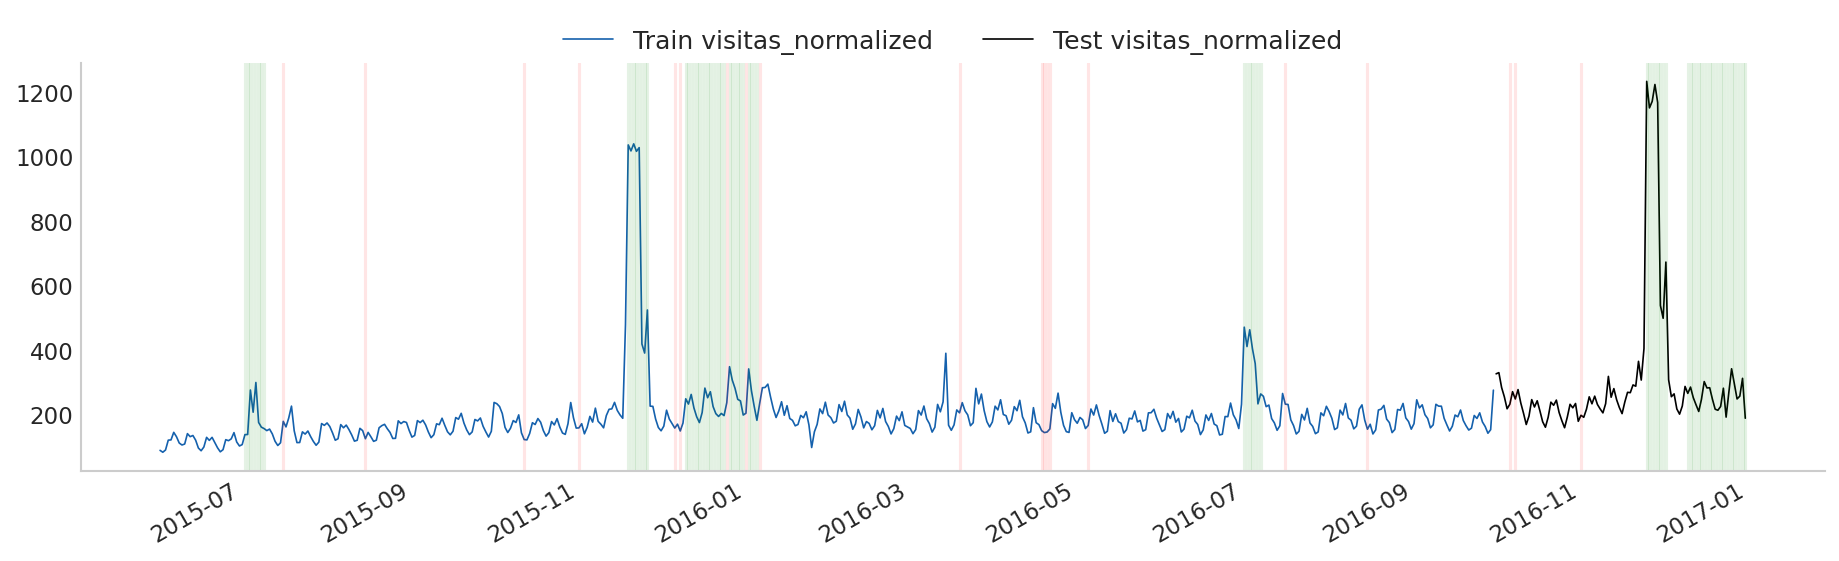

In [ ]:
plot(train, 'visitas_normalized', test, holidays)

<br><br>
**Visualización de la diferencia entre visitas normalizadas por el ratio de las medianas y visitas multiplicadas por 5 antes del 25 de enero**

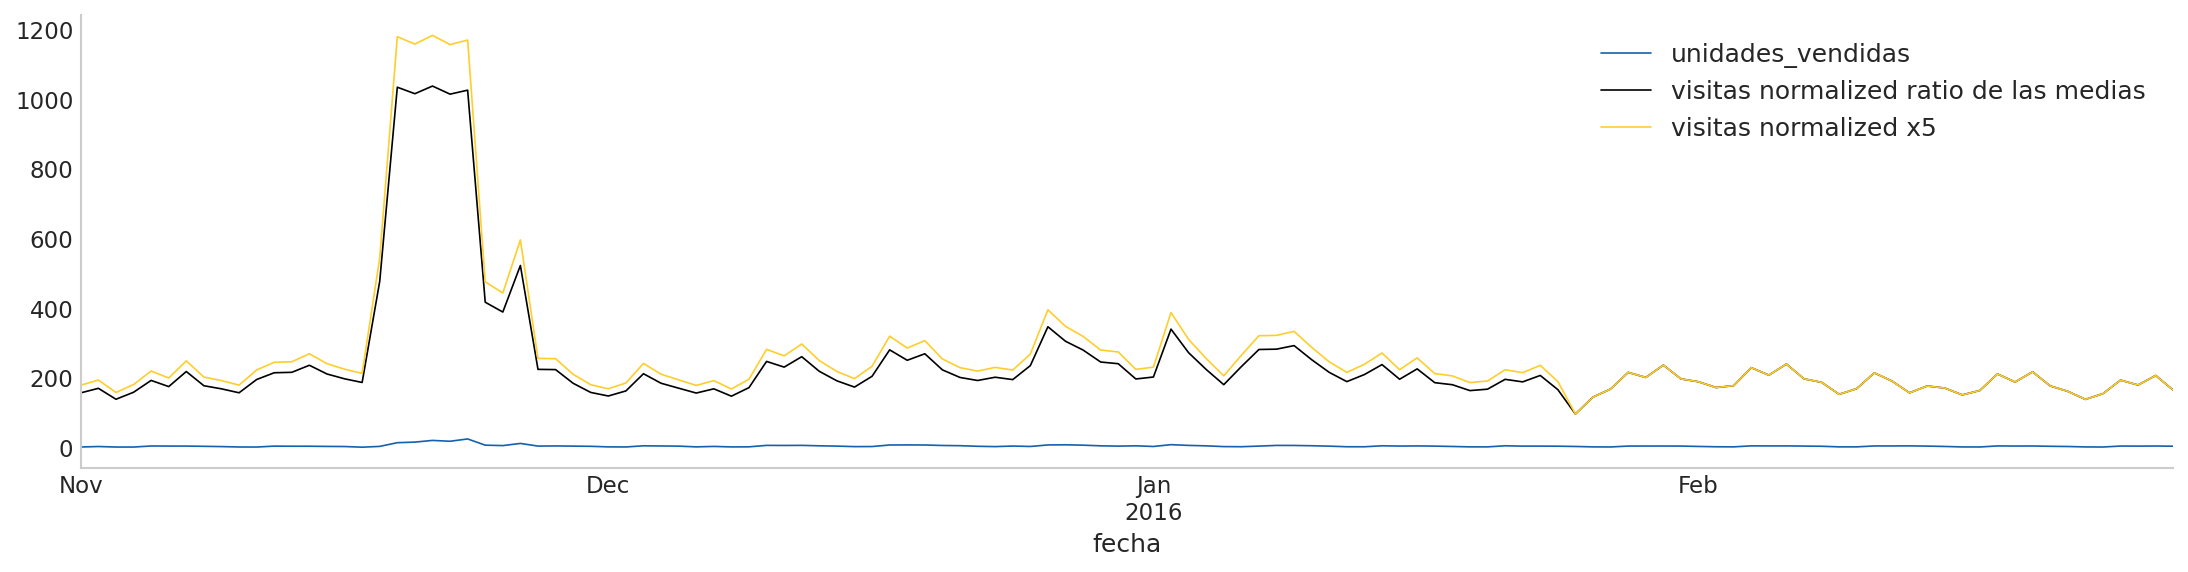

In [ ]:
# create df with dates between Nov15 and Jan16, group by fecha and aggregate it with MEAN
df_nov15_to_jan16 = df[(df['fecha'] >= '2015-11-01') & (df['fecha'] <= '2016-02-29')]
g1 = df_nov15_to_jan16.groupby(['fecha']).mean()

fig, ax = plt.subplots(figsize=(18,4))
#ax2 = ax.twinx()

#_ = test.plot(ax=ax, y='visitas', lw=.8) # no unidades_vendidas in the test_set
_ = g1.plot(ax=ax, y='unidades_vendidas', lw=.8)
_ = g1.plot(ax=ax, y='visitas_normalized',label='visitas normalized ratio de las medias', lw=.8)
_ = g1.plot(ax=ax, y='visitas_normalized2',label='visitas normalized x5', lw=.8)

Por último, eliminamos la variable _visitas_ y _visitas_normalized_ ya que nos quedamos con la variable _visitas_normalized2_:

In [ ]:
# drop visitas, visitas_normalized
df.drop(columns=['visitas','visitas_normalized'],inplace=True)
df_test.drop(columns=['visitas','visitas_normalized'],inplace=True)

<br><br>
### 2.6 Definir nuevas variables

El último paso de nuestro preprocesado va a ser la creación de algunas variables de tiempo que nos van a ser útiles para nuestro análisis y para nuestros modelos. Además, crearemos una nueva variable que tiene en cuenta la variable _categoria_uno_ y el trend de las _visitas_

In [ ]:
g_train = df.groupby(['fecha', 'categoria_uno']).sum().reset_index()
g_test = df_test.groupby(['fecha', 'categoria_uno']).sum().reset_index()

g = pd.concat([g_train, g_test])
p = g.pivot(index='fecha', columns='categoria_uno', values='visitas_normalized2')

g = g.groupby('fecha').sum().reset_index()
g['overall_trend'] = seasonal_decompose(
    g['visitas_normalized2'],
    model='additive',
    period=7
).trend
g['overall_trend'] = g['overall_trend'].ffill().bfill()


p = p.reset_index().merge(g[['fecha', 'overall_trend']], on='fecha', how='left')

p = p.set_index('fecha')

In [ ]:
for col in p:
    if p[col].sum() >= 1e6:
        trend = seasonal_decompose(
            p[col],
            model='additive',
            period=7
        ).trend
        p[col] = trend.ffill().bfill()
    else:
        p[col] = p['overall_trend']
        
p.drop(columns=['overall_trend'], inplace=True)

In [ ]:
category_trends = p.melt(
    ignore_index=False,
    value_name='categoria_uno_trend',
    var_name='categoria_uno'
).reset_index()

In [ ]:
df.drop(columns=['categoria_uno_trend'], errors='ignore', inplace=True)
df_test.drop(columns=['categoria_uno_trend'], errors='ignore', inplace=True)
df = df.merge(category_trends, on=['fecha', 'categoria_uno'], how='left')
df_test = df_test.merge(category_trends, on=['fecha', 'categoria_uno'], how='left')

In [ ]:
def add_time_segments(df):
    df['year'] = df['fecha'].dt.year
    df['month'] = df['fecha'].dt.month
    df['day'] = df['fecha'].dt.day
    df['week_number'] = df['fecha'].dt.isocalendar().week
    df['day_of_week'] = df['fecha'].dt.dayofweek
    return df

df = add_time_segments(df)
df_test = add_time_segments(df_test)

<br><br>
# <a name="explorandoDatos"> 3. Análisis exploratorio de los datos

## Objetivo:

Los principales objetivos de esta sección son:
- Entender las variables dadas para resolver el problema. Para ello dividiremos las variables entre la variable a predecir, las variables categóricas y las variables numéricas.
- Investigar las relaciones entre variables, y en particular, poner nuestro enfoque en encontrar relaciones entre la variable a predecir y el resto de variables.
- Utilizar este análisis para elegir que variables nos van a aportar más información al aplicarlas a nuestros modelos y explorar la posibilidad de agregar las variables existentes o de crear nuevas variables a partir de las mismas.

### Tipos de variables

Podemos dividir las variables obtenidas del preprocesado de la siguiente manera:

- Variable a predecir: _unidades_vendidas_

- Variables categóricas: _id, categoria_uno, categoria_dos, estado, dia_atipico, campaña, categoria_uno_trend, year, month, day, week_number, day_of_week_

- Variables numéricas: _precio, visitas_normalized2, antiguedad, precio_

Primero de todo, resulta importante asegurarnos que las variables estan en el formato correcto.

In [ ]:
df_numerical = df.select_dtypes(include=['number'])
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2029816 entries, 0 to 2029815
Data columns (total 5 columns):
 #   Column               Dtype  
---  ------               -----  
 0   precio               float64
 1   antiguedad           float64
 2   unidades_vendidas    int64  
 3   visitas_normalized2  int64  
 4   month                float64
dtypes: float64(3), int64(2)
memory usage: 157.4 MB


In [ ]:
df_categorical = df.select_dtypes(include=['object'])
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2029816 entries, 0 to 2029815
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   id             object
 1   categoria_uno  object
 2   categoria_dos  object
 3   estado         object
 4   dia_atipico    object
 5   campaña        object
dtypes: object(6)
memory usage: 172.9+ MB


### Redefiniendo las variables

In [ ]:
dtypes = {
    'categoria_uno_trend': str,
    'year': str,
    'month': float,
    'day': str,
    'week_number': str,
    'day_of_week': str,
}
df = df.astype(dtypes)

df_test = df_test.replace('-', 0).astype(dtypes)
df_test = df_test.astype(dtypes)

<br><br>
## Estudiando la variable a predecir: _unidades_vendidas_

### Principales características

Vamos a echar un primer vistazo a la variable:

In [ ]:
unidades_vendidas_unique = sorted(set(df['unidades_vendidas']))

print(f'Primeros 15 valores de la variable unidades_vendidas { unidades_vendidas_unique[:15]}')

Primeros 15 valores de la variable unidades_vendidas [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42]


In [ ]:
df['unidades_vendidas'].describe()

count    2.029816e+06
mean     3.483282e+00
std      1.715976e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.000000e+00
max      4.881000e+03
Name: unidades_vendidas, dtype: float64

In [ ]:
df['unidades_vendidas'].value_counts()

0       1397989
3        287828
6        127039
9         64180
12        37912
         ...   
516           1
504           1
501           1
1521          1
1017          1
Name: unidades_vendidas, Length: 324, dtype: int64

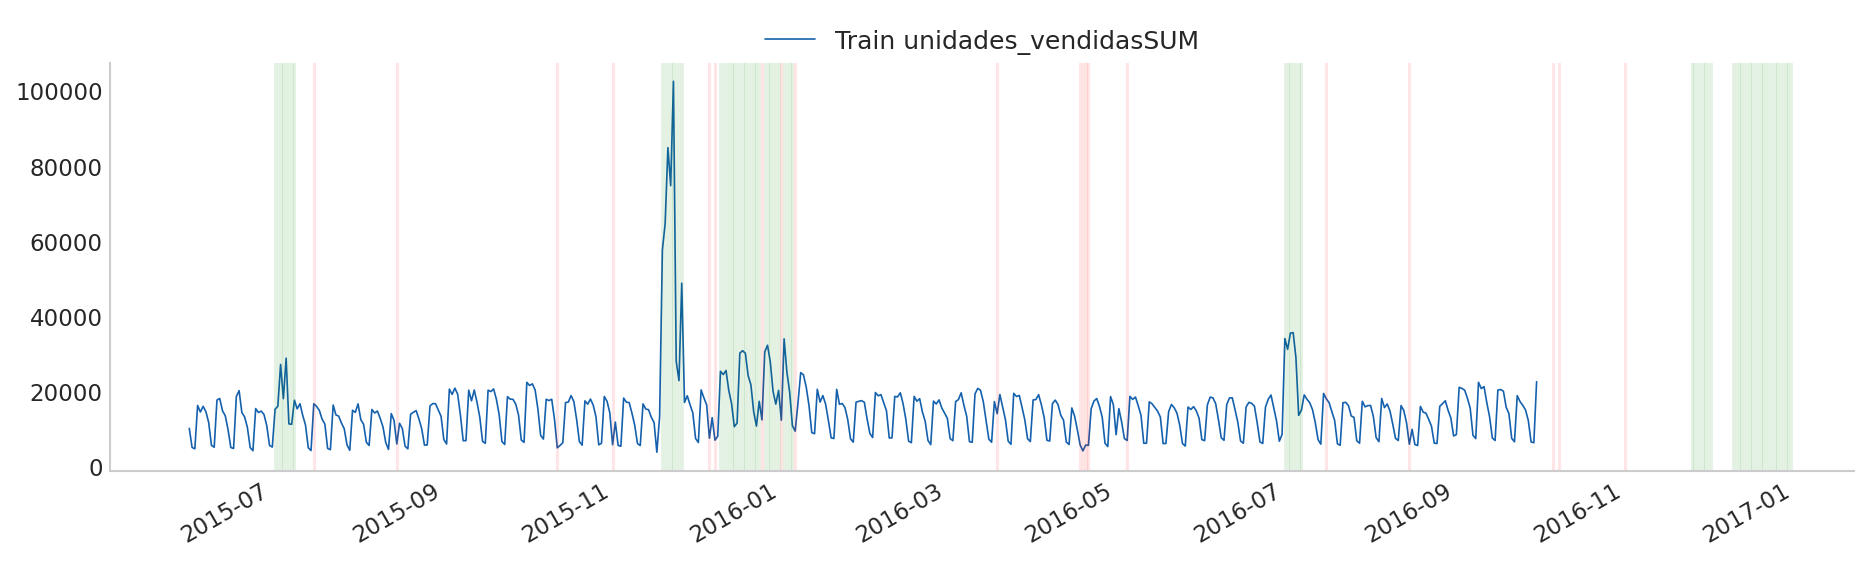

In [ ]:
plot(train_uds, 'unidades_vendidas', holidays=holidays, agg='SUM')

/Users/pepmarti23/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Min: 0.6160164271047228 
Lower Whisker: (1st quartile -1.5*(interquartile range)) -2.2176591375770025 
Upper Whisker(1st quartile +1.5*(interquartile range)): 6.455852156057495 
Max 126.51745379876797


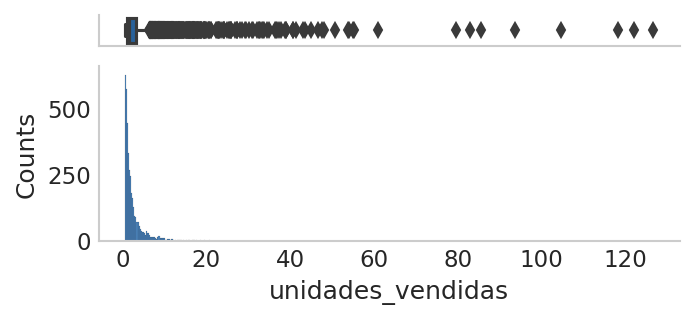

In [ ]:
g_product = df.groupby(['id']).mean()
f, (ax_box, ax_dist) = plt.subplots(2, figsize=(5,2), sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot('unidades_vendidas', data=g_product, ax=ax_box) #, color='blue'
sns.histplot(g_product['unidades_vendidas'], kde=False, ax=ax_dist,binwidth=0.25) #, color='blue'
ax_dist.set_ylabel('Counts')
ax_box.set_xlabel('')
Min = g_product['unidades_vendidas'].min()
Q1 = g_product['unidades_vendidas'].quantile(0.25) # first quartile
Q3 = g_product['unidades_vendidas'].quantile(0.75) # third quartile
IQR = Q3-Q1 # interquartile
Lower_Whisker = Q1 - 1.5*IQR
Upper_Whisker = Q3 + 1.5*IQR
Max = g_product['unidades_vendidas'].max()
print('Min:',Min,'\nLower Whisker: (1st quartile -1.5*(interquartile range))' \
      ,Lower_Whisker, '\nUpper Whisker(1st quartile +1.5*(interquartile range)):',Upper_Whisker,'\nMax',Max)

<br>

**Observaciones**

- Cabe destacar que las unidades_vendidas van de tres en tres. Esto nos llama mucho la atención pero se decide que no vamos a tomar ninguna acción. También se observa que el tercer cuartil es igual a 3. Esto significa que el 75% de las unidades vendidas son o bien 0 o 3.
- Esta variable es una variable con muchos zeros. Es decir hay muchas combinaciones de producto y fecha con 0 _unidades_vendidas_. Debemos estudiar la posibilidad de utilizar una transformación ya que claramente su distribución no sigue una distribución normal. Cabe recordar que los modelos funcionan mejor cuando la variable a predecir sigue una distribución normal. Posteriormente, barajamos la transformación _Log-normal_ y _Box-Cox_.
- El gráfico indica una fuerte seasonality semanal y dependencia del periodo del año y de las diferentes campañas.

### Estudiando diferentes transformaciones

#### Transformación Log-normal

Vamos a aplicar una transformación Log-normal modificada para nuestro caso, en que se tienen muchos valores igual a zero:

$$y = log(x+1)$$

In [ ]:
# log norm of unidades_vendidas to get a more normal distribution (better for modelling)
df['unidades_vendidas_normlog'] = np.log1p(df['unidades_vendidas'])

/Users/pepmarti23/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



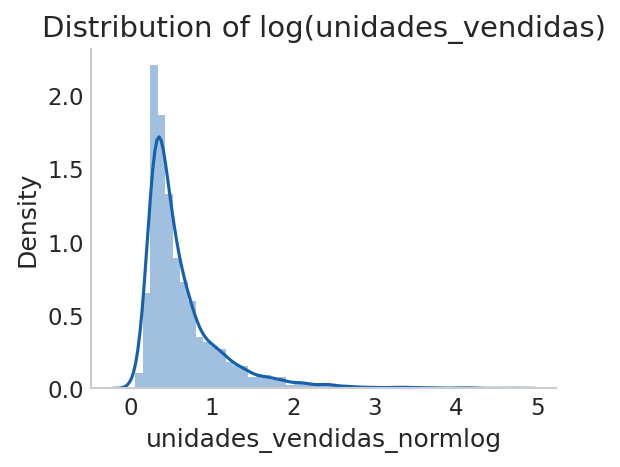

In [ ]:
# groupby product
g_product = df.groupby('id').mean()

# plot distribution
plt.figure(figsize=(4,3))
plt.title("Distribution of log(unidades_vendidas)")
sns.distplot(g_product['unidades_vendidas_normlog'])

In [ ]:
from scipy.stats import boxcox
from scipy import stats

In [ ]:
#Skewness and kurtosis
def measures_of_shape(feature):
    print("Skewness: %f" % df[feature].skew())
    print("Kurtosis: %f" % df[feature].kurt())

In [ ]:
measures_of_shape('unidades_vendidas_normlog')

Skewness: 1.532953
Kurtosis: 1.718287


**Observación**
- La distribución tiene menos skewness a la derecha, pero aún así difiere ya que tiene un skewness mayor que uno
- Esta transformación preve ser implementada a la modelización como parte de **futuros pasos**
- En un futuro se estudiará la adición de la transformación Box-Cox

### Una breve ojeada a la transformación Box-Cox
Esta transformación nos puede ser útil ya que nos permite reducir la Skewness a un número menor que uno, por lo que nuestra variable a predecir tendría una distribución mucho más similar a una normal.

In [ ]:
# Apply Box-Cox Transform to value column and assign to new column y
df['unidades_vendidas_boxcox'], lam = stats.boxcox(df['unidades_vendidas']+1)

In [ ]:
measures_of_shape('unidades_vendidas_boxcox')

Skewness: 0.844519
Kurtosis: -1.244767


/Users/pepmarti23/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



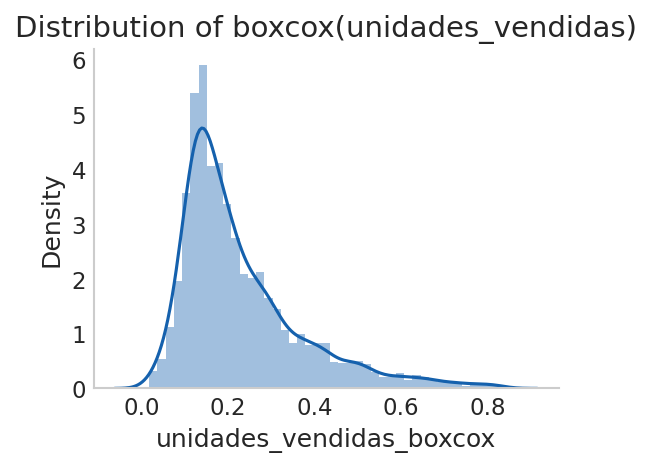

In [ ]:
# groupby product
g_product = df.groupby('id').mean()

# plot distribution
plt.figure(figsize=(4,3))
plt.title("Distribution of boxcox(unidades_vendidas)")
sns.distplot(g_product['unidades_vendidas_boxcox'])

<br><br>
## Variables Numéricas

Como es la relación (correlación) entre variables? Dibujemos un mapa de calor con los coeficientes de correlación para poder derivar algunas observaciones:

In [ ]:
# correlation heatmap sorted
def clustermap(df):
    sns.clustermap(df.corr(), cmap='RdBu',center=0,annot=True)

In [ ]:
# drop transformations of unidades_vendidas
df.drop(columns=['unidades_vendidas_normlog','unidades_vendidas_boxcox'],inplace=True)

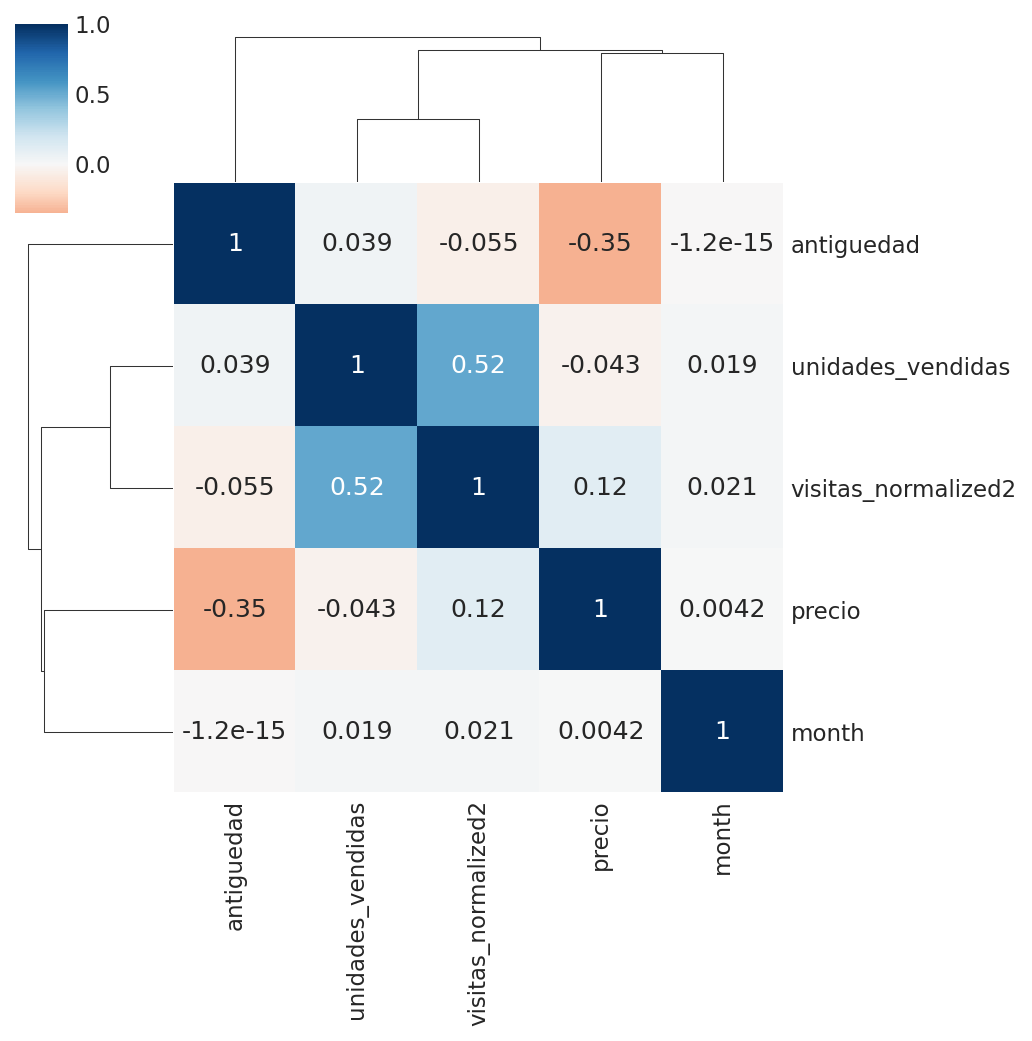

In [ ]:
sns.clustermap(df.corr(), cmap='RdBu',center=0,annot=True,figsize=(7,7))

<br><br>
**Observaciones**
- unidades_vendidas y visitas_normalized2 tienen una correlación positiva alta ( r^2 = 0.52). A parte de con visitas_normalized2, no existe otra correlación alta entre unidades_vendidas el resto de variables.

- Precio y visitas_normalized2 estan ligeramente correlacionadas positivamente (r^2 = 0.12)
- Precio y antiguedad tienen una alta correlación negativa (r^2 = -0.36)

<br><br>
## Variables Categóricas

Primero de todo, repasemos cuales son nuestras variables categóricas y cuántos valores únicos tienen cada una de ellas: 

In [ ]:
df.select_dtypes(include=['object']).nunique().sort_values(ascending=False)

categoria_uno_trend    5723
id                     4168
categoria_dos           183
week_number              53
day                      31
categoria_uno            13
day_of_week               7
estado                    3
dia_atipico               3
campaña                   2
year                      2
dtype: int64

**Observaciones**
- Hay que tener en cuenta que para las variables categóricas no existe una manera sencilla de poder estudiar su correlación. Sin embargo, tenemos otras técnicas y observaciones que deducimos de entender las variables. Por ejemplo, ya hemos podido ver que las unidades_vendidas dependen del día de la semana.
- Variables con muchos valores unicos tendrán 'pocos' valores distintos dentro de cada uno de esos valores únicos, por lo que van a ser menos precisos a la hora de hacer predicciones.


## Análisis de una sola variable

### Id
Tener claro como se comportan los productos es importante ya que forman parte del núcleo del problema. Esto es debido a que precisamente tenemos que predecir su venta por día.

In [ ]:
g_fecha = df.groupby(['fecha']).count()
g_fecha_test = df_test.groupby(['fecha']).count()

¿Tenemos el mismo número durante todo el periodo a analizar?

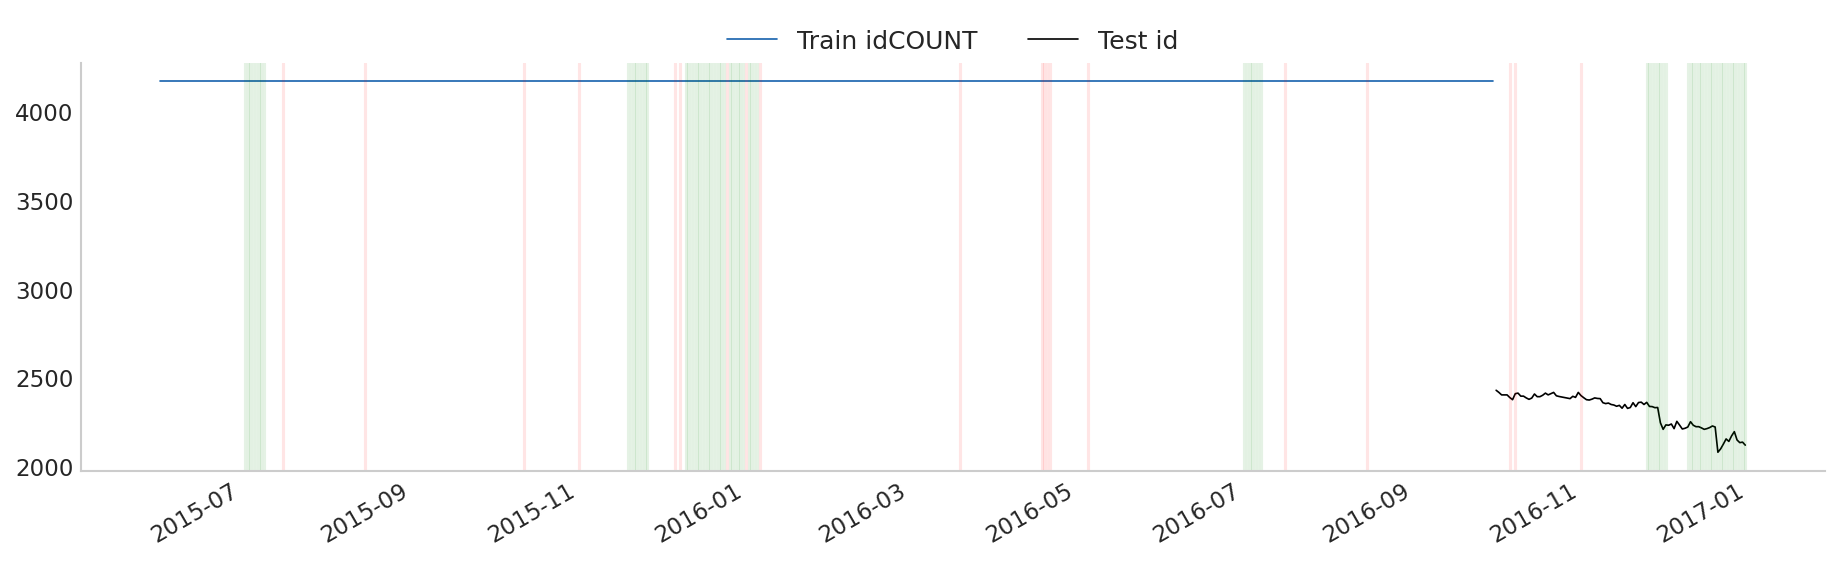

In [ ]:
plot(g_fecha,'id',g_fecha_test,holidays,'COUNT')

Podemos observar como mientras en el conjunto de modelado el número de id's permanece estable, en el conjunto de predicción el número cambia y no sigue un patrón estable.

<br>

### Análisis de las variables númericas

In [ ]:
# group by fecha
g_fecha =df.groupby(['fecha']).mean()

#### Visitas (normalizadas)

In [ ]:
def box_dist_plot(df,Feature):
    f, (ax_box, ax_dist) = plt.subplots(2, figsize=(4,2), sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(Feature, data=df, ax=ax_box) #, color='blue'
    sns.histplot(df[Feature], kde=False, ax=ax_dist,binwidth=0.25) #, color='blue'
    ax_dist.set_ylabel('Counts')
    ax_box.set_xlabel('')
    Q1 = df[Feature].quantile(0.25) # first quartile
    Q3 = df[Feature].quantile(0.75) # third quartile
    IQR = Q3-Q1 # interquartile
    Lower_Whisker = Q1 - 1.5*IQR
    Upper_Whisker = Q3 + 1.5*IQR
    print('Lower Whisker:',Lower_Whisker, 'Upper Whisker:',Upper_Whisker)

/Users/pepmarti23/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



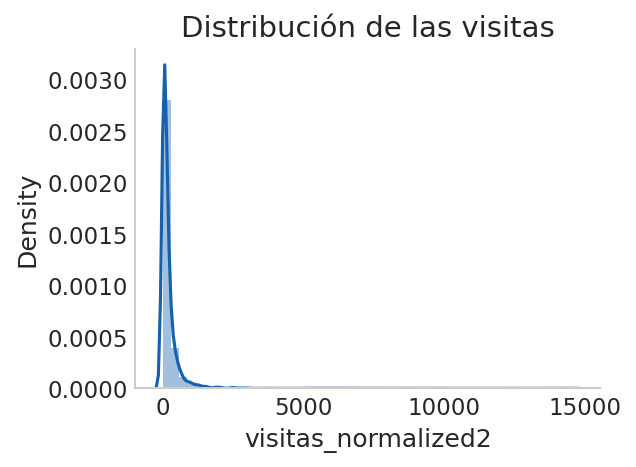

In [ ]:
# groupby product
g_product = df.groupby('id').mean()

# plot distribution
plt.figure(figsize=(4,3))
plt.title("Distribución de las visitas")
sns.distplot(g_product['visitas_normalized2'])

**Observaciones**
- Como era de esperar, la media de visitas por producto es muy similar a la de unidades_vendidas por producto.

<br>

#### Precio

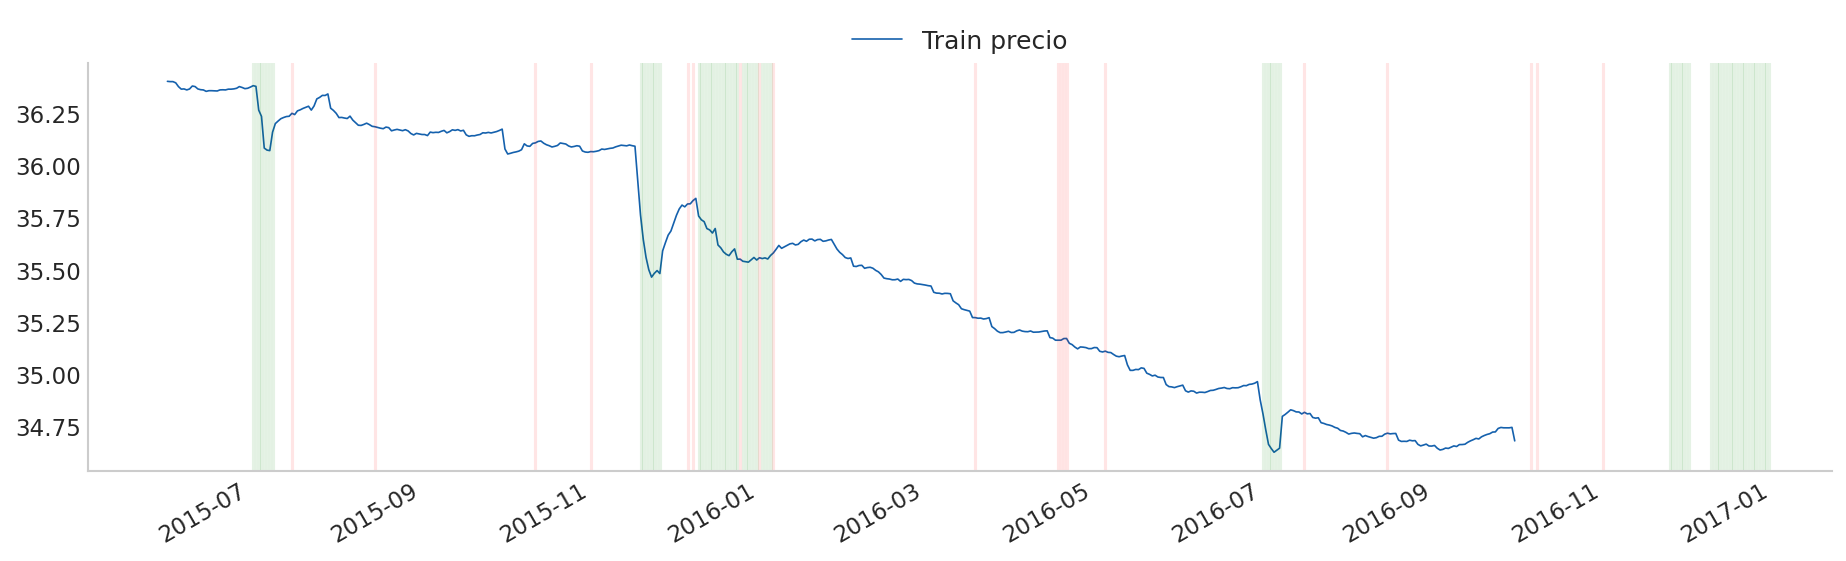

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
_ = train.plot(ax=ax, y='precio', lw=.8)
labels = [f'Train precio']
    
ax.legend(
    labels,
    ncol=3,
    bbox_to_anchor=(0.5, 1.15),
    prop={'size': 12},
    frameon=False
)
    
if holidays is not None:
    for holiday in holidays.to_dict('records'):
        if holiday['dia_atipico'] == 1:
            plt.axvline(x=holiday['fecha'], alpha=.1, color='green')
        elif holiday['dia_atipico'] == -1:
            plt.axvline(x=holiday['fecha'], alpha=.1, color='red')

_ = ax.set_xlabel('')

/Users/pepmarti23/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Lower Whisker: -39.315000000000005 Upper Whisker: 103.36500000000001


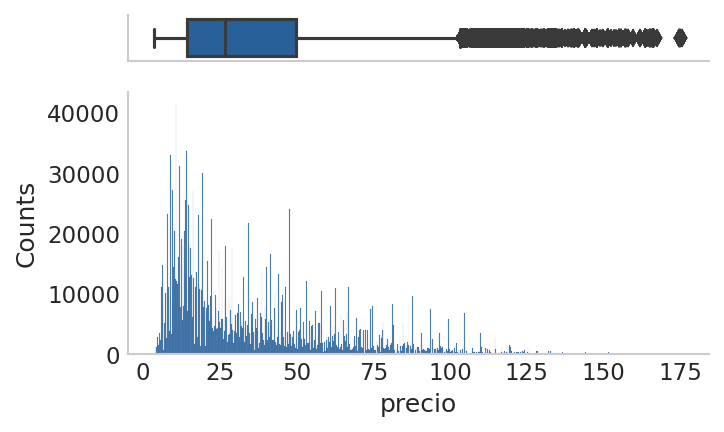

In [ ]:
box_dist_plot(df,'precio')

**Observaciones**
- El precio tiene una tendencia negativa, dónde también se puede apreciar como las fechas de campaña afectan a la media del precio. Esto puede ser debido a diferentes comportamientos.
    - Por un lado, al coger la media y al tener estos dias mucha demanda, la posibilidad de que se vendan más los productos más baratos es muy probable. (y consecuentemente la media agrupada disminuye de manera significativa)
    - Por otro lado, en estas fechas los descuentos son comunes, así que no es de extrañar que el precio sea menor.
- El 75% de los productos tienen un precio entre 20eur y 50eur, aproximadamente.

<br><br>
## Relaciones destacables

### unidades_vendidas y visitas

In [ ]:
# group by fecha
g1 =df.groupby(['fecha']).sum()

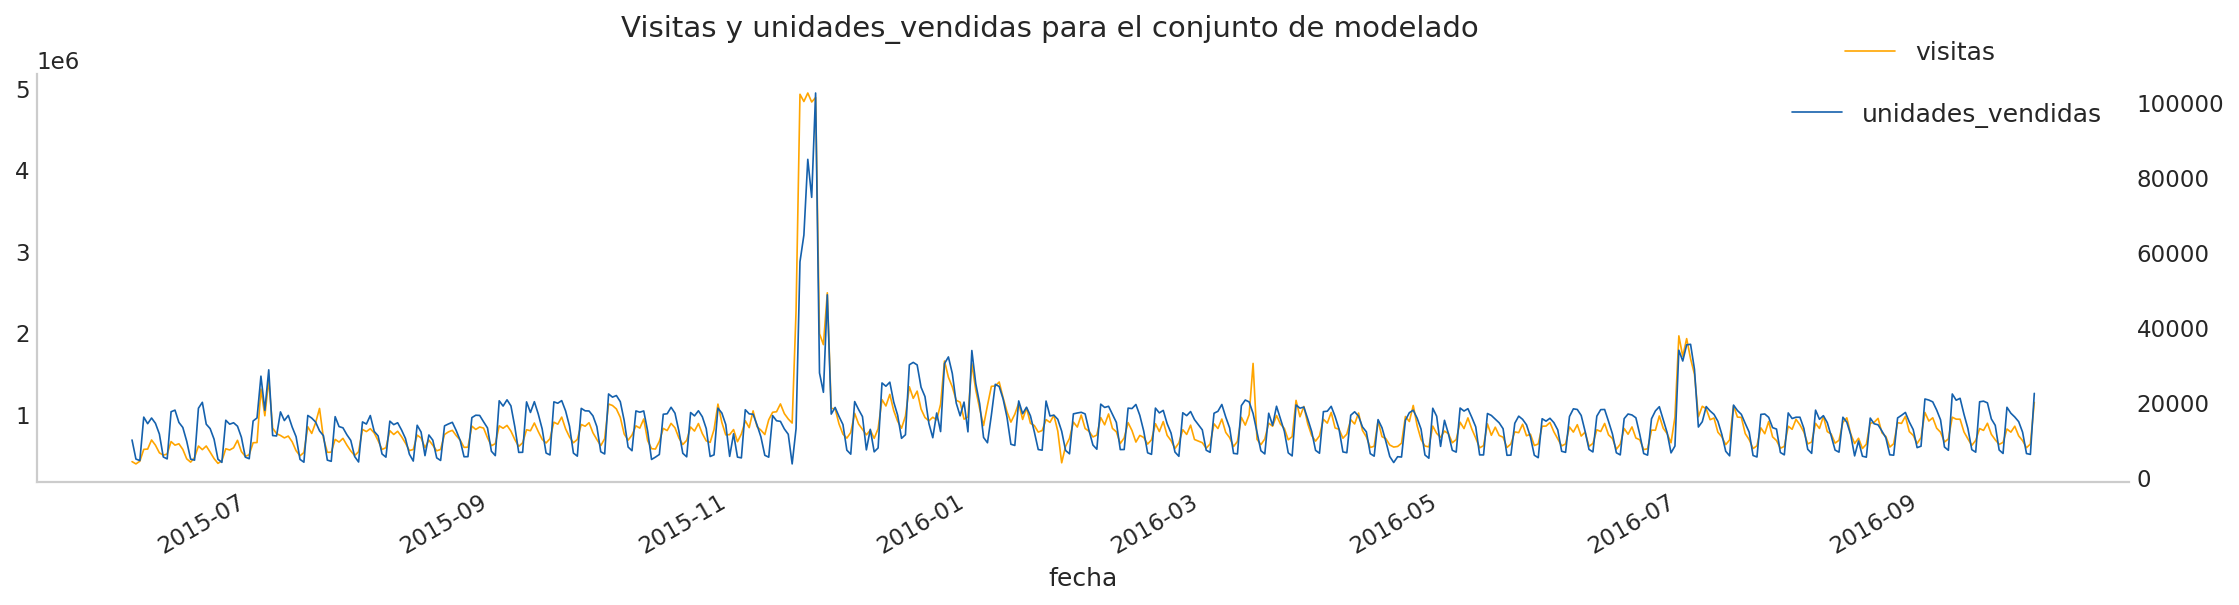

In [ ]:
# plotting visitas
fig, ax = plt.subplots(figsize=(18,4))
ax2 = ax.twinx()

_ = g1.plot(ax=ax, y='visitas_normalized2', lw=.8,label='visitas',color='orange')
_ = g1.plot(ax=ax2, y='unidades_vendidas', lw=.8,label='unidades_vendidas')
_ = fig.suptitle('Visitas y unidades_vendidas para el conjunto de modelado', fontsize=14)

ax.legend(ncol=3, bbox_to_anchor=(0.9, 1.15), frameon=False)

for df_aux in [df_test, df]:
    high_demand = set(df_aux[df_aux.dia_atipico == 1]['fecha'])
    for date in high_demand:
        plt.axvline(x=date, alpha=.1, color='green')

    low_demand = set(df_aux[df_aux.dia_atipico == -1]['fecha'])
    for date in low_demand:
        plt.axvline(x=date, alpha=.1, color='red')

In [ ]:
def scatterplot(df,x_data,y_data):
    # create jointplot: Scatterplot between two features with distplot on each axis 
    g = sns.jointplot(data=df, x=x_data, y=y_data, palette="pastel",height=6,kind="reg")
    #plt.subplots_adjust(top=0.9)
    g.fig.suptitle("Relationship")
    g.set_axis_labels(x_data, y_data)
    #g.add_legend();

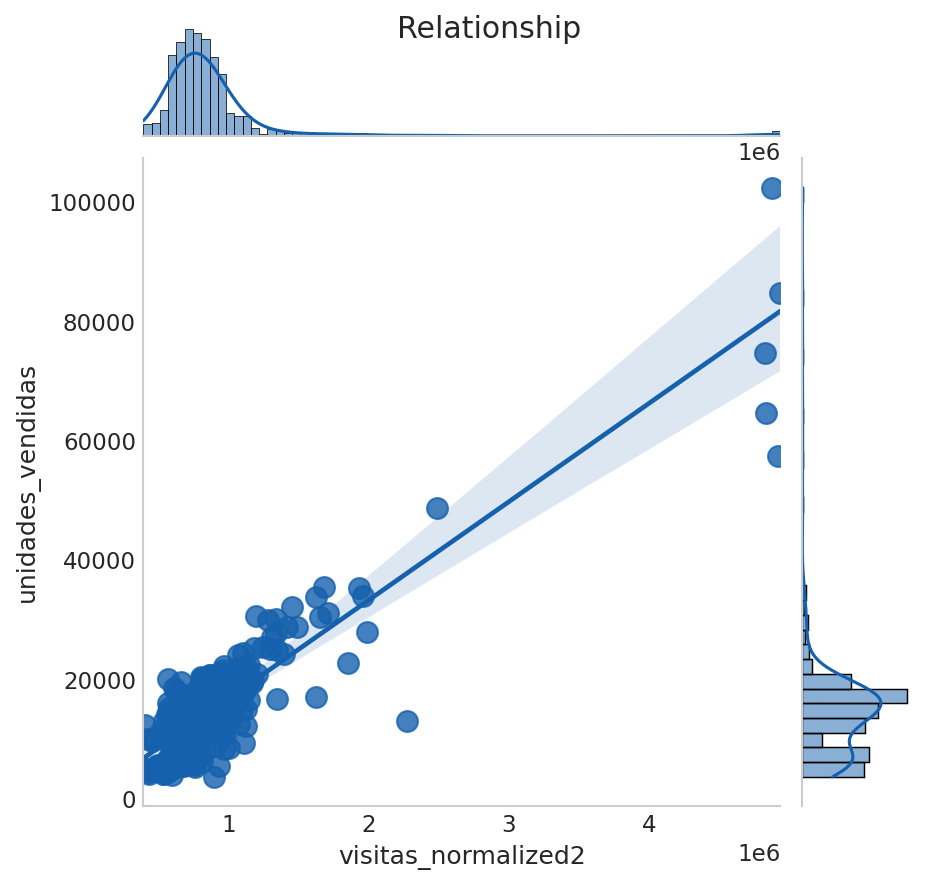

In [ ]:
scatterplot(g1,'visitas_normalized2','unidades_vendidas')

**Observaciones**
- Se puede observar la alta correlación entre estas dos variables.
- Del gráfico, se destaca como la varianza de las unidades_vendidas es mayor que el de las visitas. Agrupando nuestras variables por fecha, en el último gráfico se observa que la distribución de las visitas sigue una distribución normal, mientras que la distribución para las unidades_vendidas se parece mas a una distribución bimodal.

<br>

### Estado

#### visitas y unidades vendidas por estado

In [ ]:
# create a df for the three different estados
df_rotura = df[ df['estado'] == 'Rotura' ]
df_transito = df[ df['estado'] == 'Transito' ]
df_no_rotura = df[ df['estado'] == 'No Rotura' ]

g1 = df_rotura.groupby('fecha').sum()
g1['fecha'] = g1.index.get_level_values('fecha')
#g1 = g1[ g1['fecha'] > '2015-06-07']

g2 = df_transito.groupby('fecha').sum()
g2['fecha'] = g2.index.get_level_values('fecha')
#g2 = g2[ g2['fecha'] > '2015-06-07']

g3 = df_no_rotura.groupby('fecha').sum()
g3['fecha'] = g3.index.get_level_values('fecha')
#g3 = g3[ g3['fecha'] > '2015-06-07']

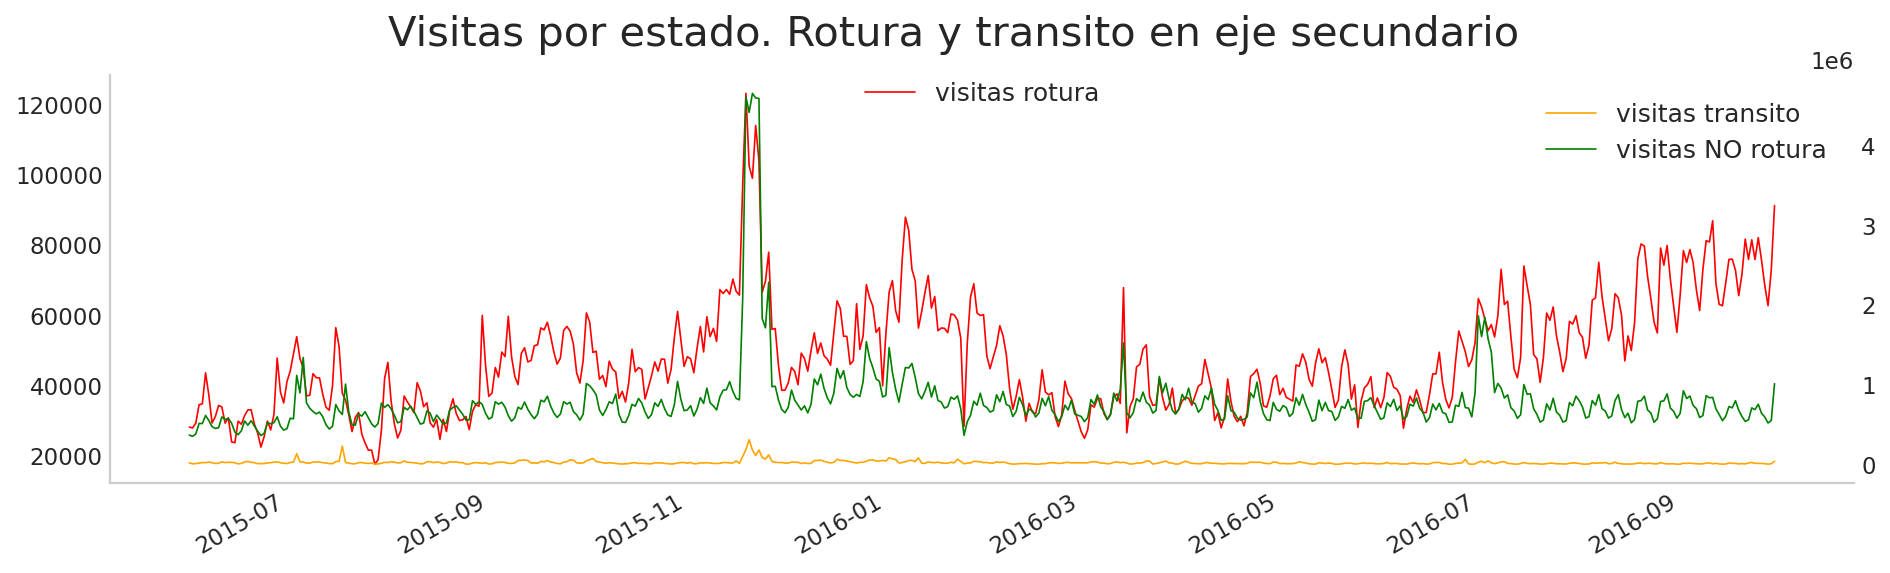

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

#_ = g.plot(ax=ax2, y='conv_rate', lw=.8)
_ = g1.plot(ax=ax, y='visitas_normalized2', lw=.8,color = 'red',label='visitas rotura')
_ = g2.plot(ax=ax2, y='visitas_normalized2', lw=.8,color = 'orange',label='visitas transito')
_ = g3.plot(ax=ax2, y='visitas_normalized2', lw=.8,color = 'green',label='visitas NO rotura')
_ = ax.legend(ncol=3, bbox_to_anchor=(0.5, 1.05), prop={'size': 12}, frameon=False)
_ = ax.set_xlabel('')
_ = fig.suptitle('Visitas por estado. Rotura y transito en eje secundario', fontsize=20)

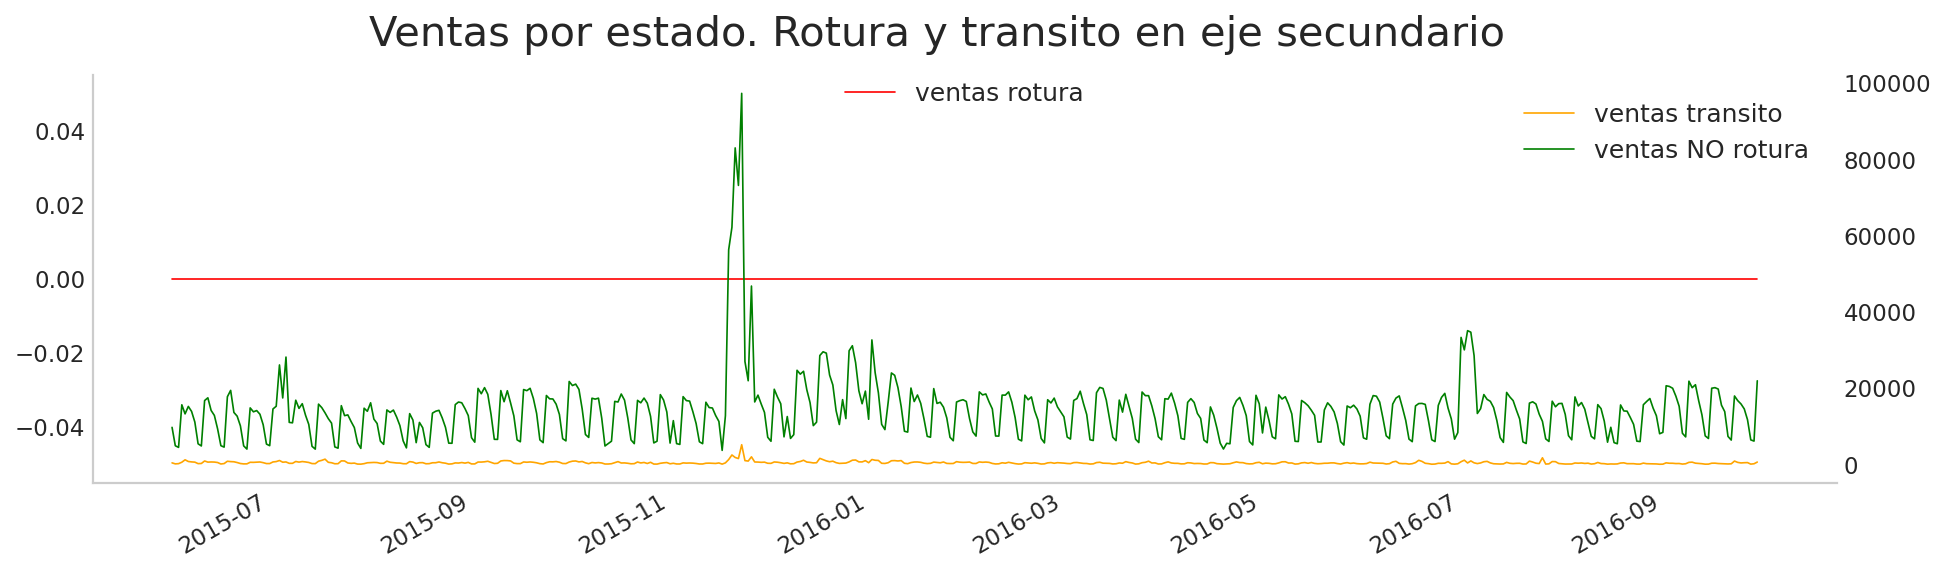

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

#_ = g.plot(ax=ax2, y='conv_rate', lw=.8)
_ = g1.plot(ax=ax, y='unidades_vendidas', lw=.8,color = 'red',label='ventas rotura')
_ = g2.plot(ax=ax2, y='unidades_vendidas', lw=.8,color = 'orange',label='ventas transito')
_ = g3.plot(ax=ax2, y='unidades_vendidas', lw=.8,color = 'green',label='ventas NO rotura')
_ = ax.legend(ncol=3, bbox_to_anchor=(0.5, 1.05), prop={'size': 12}, frameon=False)
_ = ax.set_xlabel('')
_ = fig.suptitle('Ventas por estado. Rotura y transito en eje secundario', fontsize=20)

**Observaciones**
- Primero de todo, vemos como no hay ventas cuando el estado es rotura
- Si seguimos mirando las ventas. Se puede ver como la mayor parte de las ventas se producen en estado NO rotura.
- Se puede observar una tendencia positiva en la rotura. Las visitas en rotura tienen especial importancia ya que son lo más próximo que tenemos a la demanda para un producto que no esta en stock, asi que deben de estudiarse más detalladamente.

<br>

### Día de la semana y unidades vendidas

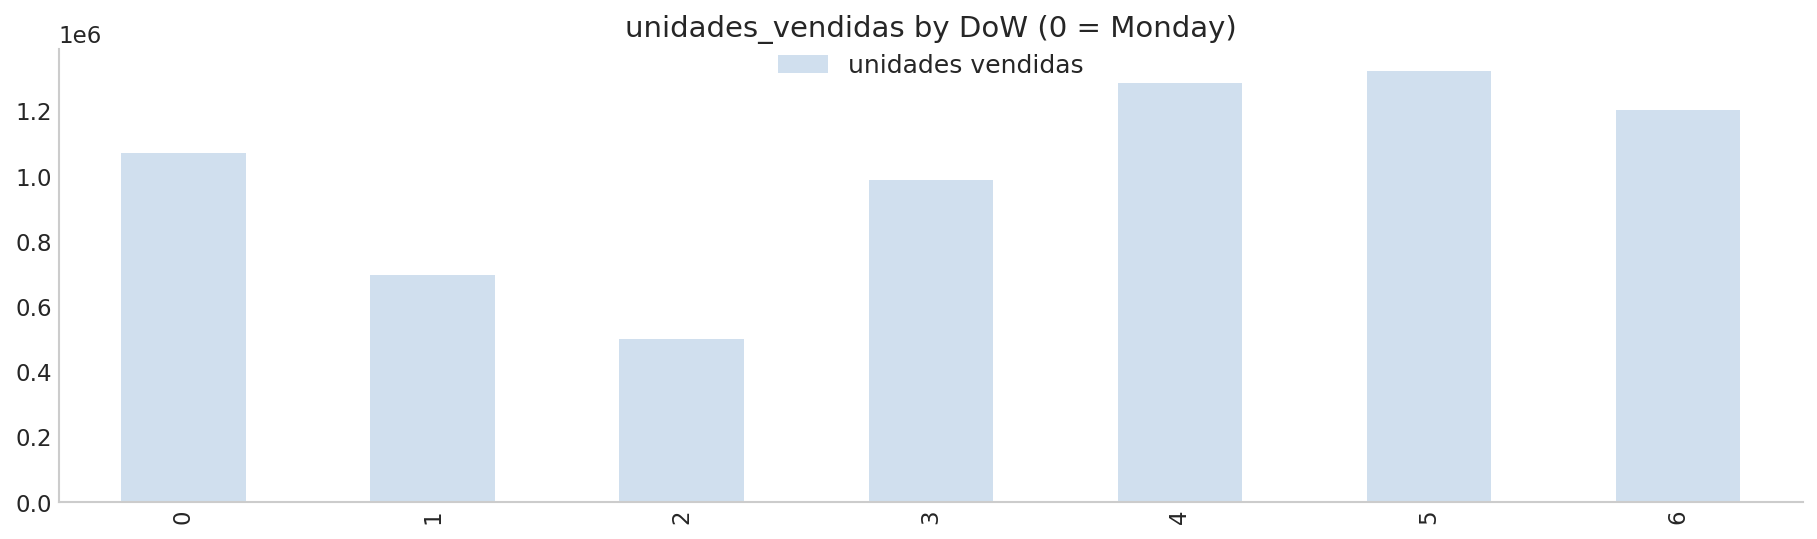

In [ ]:
df_dow = df.groupby('day_of_week').sum()

fig, ax = plt.subplots(figsize=(15,4))

_ = df_dow.plot(ax=ax, y='unidades_vendidas', kind='bar', color='C0',alpha=.2,label='unidades vendidas')
_ = ax.legend(ncol=3, bbox_to_anchor=(0.5, 1.05), prop={'size': 12}, frameon=False)
_ = ax.set_xlabel('')
_ = ax.set_title('unidades_vendidas by DoW (0 = Monday)')

In [ ]:
# mean of (total) sales
grand_avg = df['unidades_vendidas'].mean()

# Day of week pattern
dow_table = pd.pivot_table(df, index='day_of_week',
                                  values='unidades_vendidas', aggfunc=np.mean)
dow_table.unidades_vendidas /= grand_avg
display(dow_table)

,unidades_vendidas
day_of_week,
0,1.070564
1,0.684758
2,0.492294
3,0.973103
4,1.265474
5,1.321620
6,1.200657


**Observaciones**
- Hay un patrón claro por día de la semana
    - viernes, sábado y domingo destacan por encima del resto
    - martes y miércoles son los poers días
    - lunes y jueves estan entre medias

## Siguientes pasos

- Analizar de manera más detallada las relaciones entre las variables y los outliers. Referente a los outliers, nuestro objetivo es ser capaces de interpretar si eliminarlos nos beneficiaria de cara a la parte de modelización.
- Incluir un apartado de feature engineering. Creemos que va a ser muy importante ser capaces de encontrar relaciones entre variables que nos permitan o bien agregar variables que ya tenemos, o bien crear nuevas variables.
- Para la variable a predecir, explorar la posibilidad de usar las transformaciones comentadas (Log-normal y Box-Cox) para transformar la variable a predecir y intentar corregir tanto la skewness como la kurtosis.

<br><br>
# <a name="Modelos"> Modelos probados y no utilizados:

## <a name="ModeloAñoAnterior"> Modelo básico basado en las ventas del año anterior y la tendencia de los datos
### Objetivo: 
- Crear un modelo muy simple para realizar el primer pronostico de las ventas por día y producto y calcular su métrica de error. Esto nos permitirá entender la tendencia y las caracteristicas de los datos para poder aplicar este conocimiento a nuestro futuro modelo baseline.


- La base de este modelo es utilizar las ventas históricas del mismo día y producto del año anterior. Luego, trataremos de mejorar el modelo analizando los datos. Las preguntas principales que nos vamos a hacer son:
    - Hay diferencia de ventas por dia de la semana? Y por mes? Como es el crecimiento de un año para el otro para los meses que tenemos datos para 2015 y 2016?
    
- De cara a evitar introducir en modelo ruido generado por los registros en rotura, que no van a aparecer en los datos que debemos estimar, vamos a eliminar dichos registros en el conjunto de entrenamiento.

### Explorando los datos

Analizaremos los datos a través de pivot tables. En particular estudiamos el patrón que siguen la variable a predecir, _unidades_vendidas_, por mes y día de la semana. Al final, calcularemos el crecimiento de un año a otro para los mesos en que tenemos datos de los dos años.

Vamos a calcular la media de la variable a predecir, _unidades_vendidas_. Que observamos al compararlo con la media de las unidades vendidas por mes?

In [ ]:
# mean of (total) sales
grand_avg = df['unidades_vendidas'].mean()

# Monthly pattern
month_table = pd.pivot_table(df,index=['month'],values='unidades_vendidas', aggfunc=np.mean) #,columns = 'dia_atipico'
month_table /= grand_avg
#display(month_table)

# Monthly/year pattern
month_table_year = pd.pivot_table(df,index=['month'],columns=['year'],values='unidades_vendidas', aggfunc=np.mean) #,columns = 'dia_atipico'
month_table_year /= grand_avg
display(month_table_year)

year,2015,2016
month,,
1,NaN,1.101567
2,NaN,0.962848
3,NaN,0.925034
4,NaN,0.852385
5,NaN,0.872268
6,0.794307,0.888850
7,0.887513,1.149767
8,0.772683,0.818883
9,0.970112,1.025525


**Observaciones**
- Los meses que tienen un valor significantemente positivo son Noviembre, Diciembre 2015 y Enero 2016, así como Julio 2016. Esto era predecible ya que sabemos que durante estos meses tenemos la campaña de Black Friday, las compras pre-Navidad
- Por otra parte las media de unidades vendidas para Junio, Julio, Agosto 2015 y Abril, Mayo y Junio 2016 esta más de un 10% por debajo que la media del total.

Que patrones observamos por dia de la semana?

In [ ]:
# Day of week pattern
dow_table = pd.pivot_table(df, index='day_of_week',
                                  values='unidades_vendidas', aggfunc=np.mean)
dow_table.unidades_vendidas /= grand_avg
display(dow_table)

,unidades_vendidas
day_of_week,
0,1.070564
1,0.684758
2,0.492294
3,0.973103
4,1.265474
5,1.321620
6,1.200657


In [ ]:
# Day of week pattern
df_dow_dia_atipico = df.groupby(['day_of_week','dia_atipico']).mean().reset_index()

dow_dia_atipico_table = df_dow_dia_atipico.pivot(index='day_of_week',columns = 'dia_atipico',
                                  values='unidades_vendidas') #aggfunc=np.mean
dow_dia_atipico_table /= grand_avg
display(dow_dia_atipico_table)

dia_atipico,-1,0,1
day_of_week,,,
0,0.376834,0.937933,2.485766
1,0.378970,0.633565,1.218234
2,0.515246,0.443520,0.988648
3,0.665848,0.847017,1.888075
4,0.845966,1.193704,2.337585
5,0.868214,1.194623,2.586339
6,0.453255,1.102028,2.259589


**Observaciones**
- En general, los peores días de la semana en cuanto a ventas son Martes y Miércoles
- Si agregamos los días de la semana por _dia_atipico_, podemos ver como el patrón establecido es predecible, sea como sea, si es dia atipico por baja demanda (-1) las unidades vendidas serán mucho menores. Cabe destacar que incluso cuando hay mucha demanda (dia atipico = 1), los Martes y los Miércoles siguen siendo dias de poca venta.

Los únicos meses por los cuales tenemos datos de 2015 y 2016 son Junio, Julio, Agosto y Septiembre. Cual es el crecimiento de un año para el siguiente para esos meses?

In [ ]:
mask = (month_table[2015].isna() == False) & (month_table[2016].isna() == False)
yearly_growth = month_table[mask][2016].mean()/month_table[mask][2015].mean()
print("Crecimiento anual: ",yearly_growth)

Crecimiento anual:  1.1338570309115092


### Predicción

#### Separamos nuestro dataframe entre el periodo utilizado como base  y el periodo a predecir:
- El periodo base estará compuesto por las fechas comprendidas entre el 1 de julio de 2015 y 30 de septiembre de 2016. El periodo a predecir comprenderá tres meses, Julio, Agosto y Septiembre de 2016 y lo utilizaremos para evaluar nuestro modelo.

In [ ]:
# create dataframe with ly dates, which will be used as a base to forecast the sales for the validation set
mask = (df['fecha'] >= '2015-06-03') & (df['fecha'] <= '2015-10-03')
df_last_year = df.loc[mask]

df_last_year['fecha+364'] = df_last_year['fecha']+timedelta(364)
df_last_year.set_index(['fecha'],inplace=True)

# create validation set
mask = df['fecha'] >= '2016-06-01'
validation_set = df.loc[mask]
validation_set.set_index(['fecha'],inplace=True)
validation_set['fecha_col'] = validation_set.index.get_level_values('fecha')

<ipython-input-121-b0c65ca60ca1>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-121-b0c65ca60ca1>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# look up table at a product date level
producto_fecha_table = pd.pivot_table(df_last_year, index='fecha+364', columns='id',
                                  values='unidades_vendidas', aggfunc=np.mean)
#display(producto_fecha_table)

In [ ]:
# .at access a single value for a row col label pair
# to make the prediction we take into account:
# producto_fecha_table 
# month_table is a table that breaks down unidades_vendidas
# divided by total of unidades_vendidas by month for the same dates as the validation_set for last year (i.e jun15 to sep15)
# dow_table does the same as month_table but by dow, also for training set

prediction = []
for _, row in tqdm(validation_set.iterrows()):
    dow, month = row.name.day_of_week, row.name.month
    item, fecha = row['id'], row['fecha_col']
    producto_fecha_unidadesVendidas = producto_fecha_table.at[fecha, item]
    mul = month_table.at[month, 'unidades_vendidas'] * dow_table.at[dow, 'unidades_vendidas']
    pred_unidades_vendidas = producto_fecha_unidadesVendidas * mul * yearly_growth
    prediction.append(pred_unidades_vendidas)

#### Evaluación del modelo

In [ ]:
def score(self, subset=None):
    '''
    This function gives the score for the forecasts of the Atmira Stock Prediction challenge
    '''
    if subset is None:
        predictions = pd.concat(self.predictions.values())
    else:
        predictions = [self.predictions[pid] for pid in subset]
        predictions = pd.concat(predictions)
            
    mse = mean_squared_error(predictions['y'], predictions['yhat'])
    rmse = np.sqrt(mse)
    rrmse = rmse / predictions['y'].mean()
    cf = (predictions['y'] < predictions['yhat']).sum() / predictions['ds'].count()
    score = (0.7 * rrmse) + (0.3 * (1 - cf))
    return score
    
def RMSE_error(data,forecast):
    """
    This function gives the RMSE for the forecats
    """
    return np.sqrt((1/data.shape[0])*np.sum(np.square(data-forecast)))

def evaluation(y,yhat):
    print(f"The RMSe error is {RMSE_error(y,yhat)} \n")
    mse = mean_squared_error(y,yhat)
    rmse = np.sqrt(mse)
    rrmse = rmse / y.mean()
    cf = (y < yhat).sum() / len(yhat)
    score = (0.7 * rrmse) + (0.3 * (1 - cf))
    print(f"The Atmira challenge score is {score} \n")

In [ ]:
evaluation(validation_set['unidades_vendidas'],prediction)

The RMSe error is 21.65430148484956 

The Atmira challenge score is 4.703259902030639 



<ipython-input-138-ce92ecd81a71>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



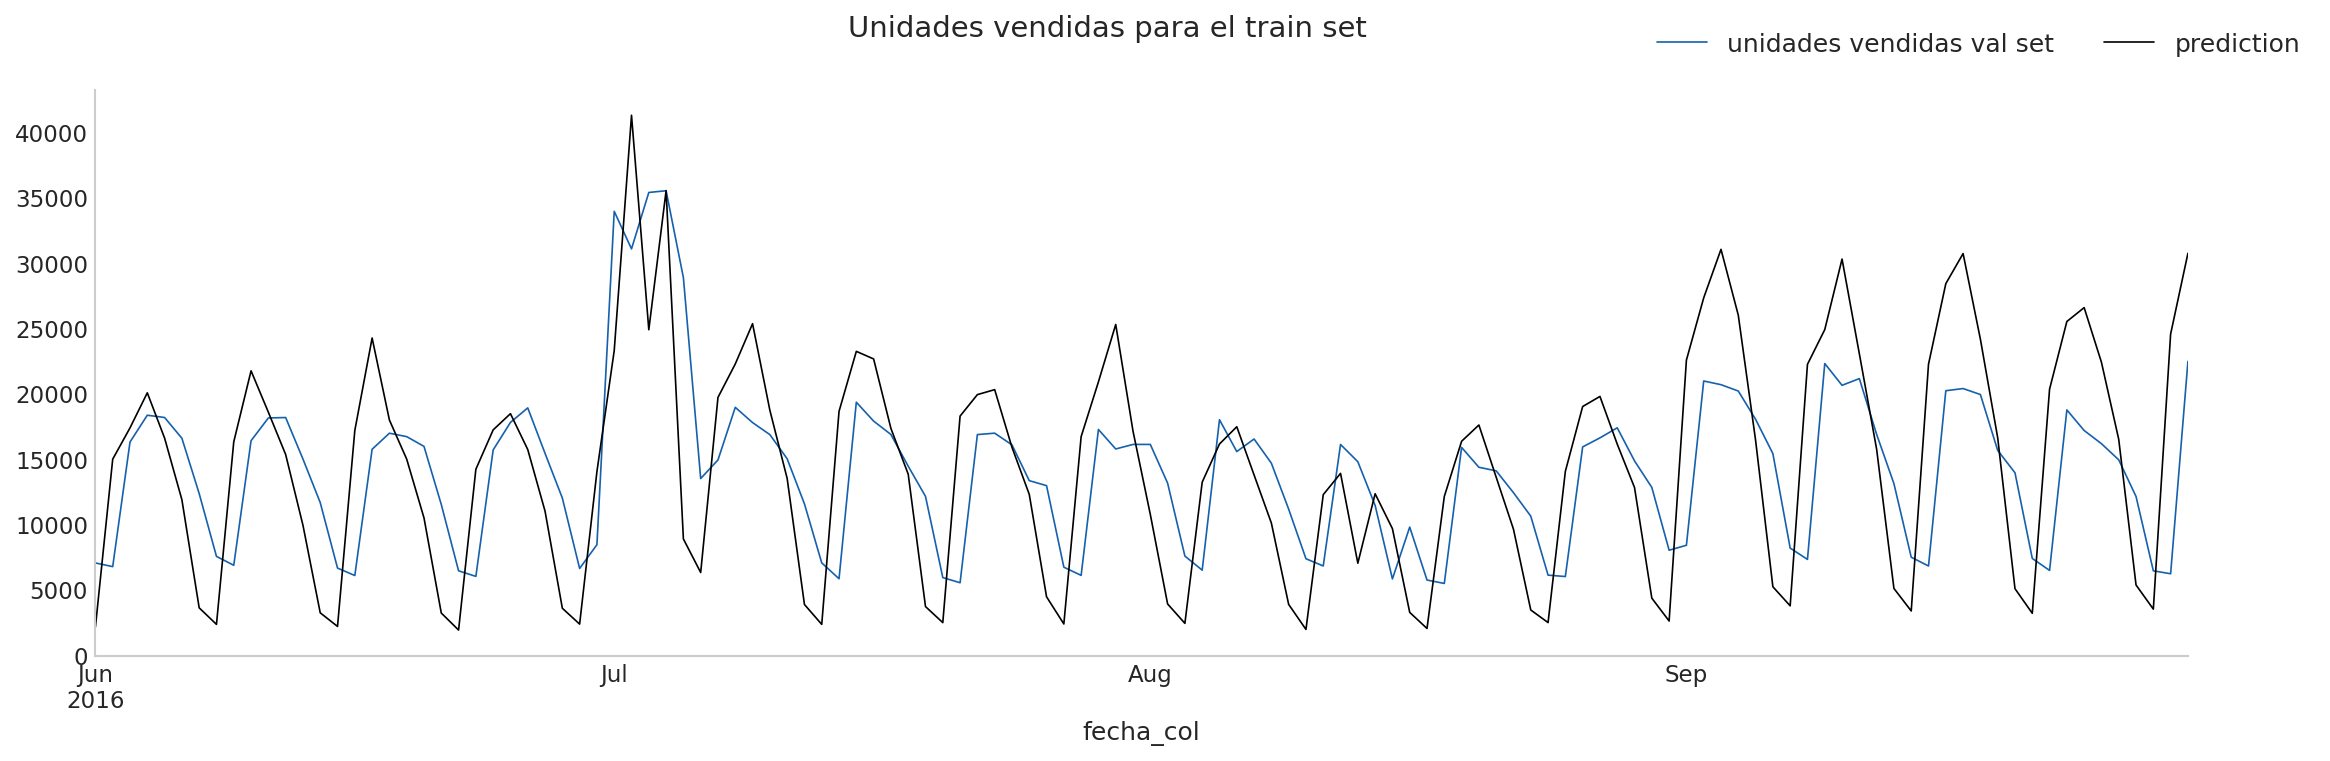

In [ ]:
validation_set['prediction'] = prediction

g_fecha_validation_set = validation_set.groupby(['fecha_col']).sum()

# plotting unidades_vendidas and prediction
fig, ax = plt.subplots(figsize=(18,5))

#_ = test.plot(ax=ax, y='visitas', lw=.8) # no unidades_vendidas in the test_set
_ = g_fecha_validation_set.plot(ax=ax, y='unidades_vendidas', lw=.8,label='unidades vendidas val set')
_ = g_fecha_validation_set.plot(ax=ax, y='prediction', lw=.8,label='prediction')
_ = fig.suptitle('Unidades vendidas para el train set', fontsize=14)

ax.legend(ncol=3, bbox_to_anchor=(0.9, 1.15), frameon=False)

<br>

### Conclusiones:
- La metodologia de usar el año anterior como base y aplicar algunos factores, todo y ser un procedimiento muy senzillo, parece ser efectivo y eficiente. Sin embargo, podremos ver como aplicando un modelo lineal Ridge nos da una predicción mucho mejor.

- Este modelo nos ha servido para entender mejor el problema, darnos un score que va a ser utilizado como base para el modelo baseline.

<br><br>


## <a name="ModeloRidge"> Modelo lineal Ridge para agrupaciones por categorías
### Objetivo: 
- Crear un modelo lineal simple para las agrupaciones principales por variables categorícas y calcular su métrica de error. Esto nos ha de permitir tener una referencia de un futuros modelos más elaborados para saber cómo de bien se estan ajustando estos a nuestro problema. 
- Para ello, utilizaremos el csv con los datos a estimar ya preprocesados, con NaNs rellenados y con algunas columnas que nos pueden ser útiles para afinar la predicción ya incluidas
- De cara a evitar introducir en modelo ruido generado por los registros en rotura, que no van a aparecer en los datos que debemos estimar, vamos a eliminar dichos registros en el conjunto de entrenamiento.


##### Importar Librerías relevantes.

In [ ]:
df = pd.read_csv('Preprocessed_data_with_norm1_norm2.csv', encoding='utf-8')
df = df.drop('Unnamed: 0', axis=1)
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y/%m/%d')
df

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,visitas_normalized2,visitas_normalized,categoria_uno_trend,year,month,day,week_number,day_of_week
0,2015-06-01,124406,10,A,197.0,No Rotura,16.16,0,0,2210.0,0,50,43.849804,169317.873994,2015,6,1,23,0
1,2015-06-02,124406,3,A,197.0,No Rotura,16.16,0,0,2210.0,0,15,13.154941,169317.873994,2015,6,2,23,1
2,2015-06-03,124406,3,A,197.0,No Rotura,16.16,0,0,2210.0,3,15,13.154941,169317.873994,2015,6,3,23,2
3,2015-06-04,124406,4,A,197.0,No Rotura,16.16,0,0,2210.0,3,20,17.539922,169317.873994,2015,6,4,23,3
4,2015-06-05,124406,12,A,197.0,No Rotura,16.16,0,0,2210.0,0,60,52.619765,172218.225305,2015,6,5,23,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2029811,2016-09-26,361726,60,F,336.0,No Rotura,69.66,0,0,361.0,0,60,60.000000,190218.571429,2016,9,26,39,0
2029812,2016-09-27,361726,125,F,336.0,No Rotura,69.66,0,0,361.0,0,125,125.000000,196790.000000,2016,9,27,39,1
2029813,2016-09-28,361726,50,F,336.0,No Rotura,69.66,0,0,361.0,0,50,50.000000,184246.428571,2016,9,28,39,2
2029814,2016-09-29,361726,100,F,336.0,No Rotura,69.66,0,0,361.0,0,100,100.000000,168217.857143,2016,9,29,39,3


### Modelo base:
- Para crear nuestro modelo de baseline, a partir del cual obtendremos una medida de error comparativa para los siguientes modelos que vayamos a utilizar, simplemente crearemos una serie de modelos lineares Ridge (Para evitar problemas dados por multicolinearidad entre las variables predictoras) para agrupaciones de registros en base a variables categoricas que consideramos que puedan influir en las unidades vendidas de cada registro.
- El modelo Ridge requiere que estandarizemos las variables independientes a la media y desviación típicas de cada variable que vayamos a utilizar. Para cada grupo, además de añadir los coeficientes para la regresión, incluiremos también el scaler correspondiente
- Las variables por las que vamos agrupar los datos serán: 
    - Día de la semana: puesto que el análisis exploratorio nos muestra grandes diferencias tanto en visitas como en unidades vendidas en cada día a lo largo de una semana.
    - Mes: Puesto que, aunque el mes no sea tan discriminante como el día de la semana, si que observamos algunas diferencias en meses particularmente activos. Adicionalmente, el objetivo final del ejercicio es predecir ventas en algunos meses concretos del años. Dadas estas diferencias, puede que solo debamos tener en cuenta los mismos meses del año anterior para generar el modelo.
    - Categoria_uno: Cada producto muestra comportamientos diferentes de compra.
- Las variables que utilizaremos como regresores para cada modelo, son:
    - Id del producto: Pese a que nuestra idea original era tratar el ID como una variable categoría, mediante el análisis previo de los datos observamos que el número de id de cada producto contiene información sobre su antiguedad, siendo muy alto el coeficiente de correlación lineal entre estas dos variables (A medida que se incorporan productos a la tienda, se utilizan ID's con valores más altos). Utilizando el id atajamos dos problemas: Nos ahorramos introducir una variable con un número no negligible de NAN's (Antigüedad) y evitamos la multicolinearidad entre estas dos variables
    - Precio: Aunque en un análisis inicial el precio no se muestre como una variable que correlacione con las visitas de forma general, vemos que dado un día y una categoría de producto, incrementa la relación negativa entre el precio de un producto y las unidades que se venden del mismo
    - Tasa de conversion: Para cada Id de producto, hemos calculado cuantas visitas son necesarias para que se produzca una venta. Podemos utilizar esta variable como regresor para el modelo.
    - Campaña: Al observar que las ventas en dias de campaña aumentan, necesitamos considerar esta variable de forma binaria para que el modelo sea capaz de predecir días y productos en los que la demanda será atípicamente alta
    - Día atípico: De la misma manera que tenemos en cuenta la campaña, tenemos en cuenta la influencia que días con demanda superior o inferior a la habitual tengan sobre la venta de productos

##### Relación entre precio y unidades vendidas para una categoría y un día dados:

In [ ]:
# Ejemplo:
group = df[(df['fecha'] == df['fecha'].min()) & (df['categoria_uno'] == 'A')]
group.corr()

,visitas,precio,antiguedad,unidades_vendidas,visitas_normalized2,visitas_normalized,categoria_uno_trend,year,month,day,week_number,day_of_week
visitas,1.000000,0.079902,0.168585,0.503936,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
precio,0.079902,1.000000,-0.215345,-0.100162,0.079902,0.079902,NaN,NaN,NaN,NaN,NaN,NaN
antiguedad,0.168585,-0.215345,1.000000,0.205210,0.168585,0.168585,NaN,NaN,NaN,NaN,NaN,NaN
unidades_vendidas,0.503936,-0.100162,0.205210,1.000000,0.503936,0.503936,NaN,NaN,NaN,NaN,NaN,NaN
visitas_normalized2,1.000000,0.079902,0.168585,0.503936,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
visitas_normalized,1.000000,0.079902,0.168585,0.503936,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
categoria_uno_trend,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Separamos nuestro dataframe entre Train y Test quedándonos los últimos 3 meses para testear el modelo:
- El motivo de hacer este corte es para validar si el modelo es capaz de predecir las ventas en un momento del tiempo específico.
- Dada la naturaleza del agrupado de modelo estilo 'Look-up table' que la funcion predictora va a utilizar para seleccionar los regresores que le corresponden a cada registro del test, podríamos hacer una partición aleatoria, pero esto nos dificultaría la visualización del ajuste de la predicción al dato real así como la comparativa con otros posible modelos que traten los datos a modo de serie temporal.

In [ ]:
df_tr = df[df['fecha'] <= '2016-06-30'].reset_index(drop=True)
df_te = df[df['fecha'] > '2016-06-30'].reset_index(drop=True)    

In [ ]:
def ridge_reg(data, indep_vars):
    x = data[indep_vars].values.reshape(-1,len(indep_vars))
    y = data['unidades_vendidas'].values.reshape(-1,1)
    X_scaler = StandardScaler()
    X_scaler = X_scaler.fit(x)
    model = Ridge()
    trained = model.fit(X_scaler.transform(x), y)
    return (trained.intercept_[0], trained.coef_[0]), X_scaler

def predict(d,group_by,ridge_coef, indep_cols):
    """
    Given, a data point, the groups by which we split and the regression coefficients, this function returns a prediction
    """
    group = tuple(d[group_by])
    scaler = ridge_coef.loc[group][0][1]
    indeps = np.array([d[x] for x in indep_cols])
    indeps = scaler.transform(indeps.reshape(-1,len(indeps)))[0]
    coefs = ridge_coef.loc[group][0]
    inter, slp = coefs[0][0], coefs[0][1]
    pred = np.floor(inter + sum([var * weight for var, weight in zip(indeps, slp)]))
    return pred if pred >= 0 else 0

In [ ]:
groupby_cols = ['month','day_of_week','categoria_uno']
indep_cols = ['visitas_normalized2', 'dia_atipico', 'campaña', 'precio', 'categoria_uno_trend']
df_ridge = df_tr.groupby(groupby_cols).apply(ridge_reg, indep_vars = indep_cols)
data_ridge = pd.DataFrame(df_ridge,columns=['Reg_Coef_and_Scaler'])
data_ridge

Reg_Coef_and_Scaler
month day_of_week categoria_uno                                                   
1     0           A              ((4.138528138528138, [3.8611862134689368, 0.41...
                  B              ((2.7877358490566047, [3.06336979506875, -0.72...
                  C              ((4.765624999999998, [2.827728756449046, -0.44...
                  D              ((0.0, [0.0, 0.0, 0.0, 0.0, 0.0]), StandardSca...
                  E              ((2.9270516717325235, [9.67752304198777, 0.832...
...                                                                            ...
12    6           I              ((7.099999999999999, [7.864667230104908, 0.630...
                  K              ((6.243521341463414, [20.306240966890766, 0.37...
                  L              ((7.919724770642203, [20.24266495398934, -0.24...
                  N              ((2.4999999999999987, [3.01240035218182, 1.588...
                  O              ((5.999999999999997, [4.275868887901918, 3.673...

[1092 rows x 1 columns]

Con el dataframe "data_ridge" tenemos para cada grupo sus coeficientes correspondientes así como el objeto Scaler ajustado de ese grupo del set de entrenamiento. A la hora de hacer la predicción, para cada registro en el test, el script buscará a qué grupo de mes, día de la semana y categoría_uno corresponde y aplicara ese Scaler y esos coeficientes. 

In [ ]:
demand_hat_1 = []
for i in tqdm(range(df_te.shape[0])):
    demand_hat_1.append(predict(df_te.iloc[i], groupby_cols, data_ridge, indep_cols))
df_te['prediction'] = demand_hat_1

### Validación del Modelo

In [ ]:
def rsme(y,yhat):
    sq_errors = [(real - pred)**2 for real, pred in zip(y, yhat)]
    return np.sqrt(sum(sq_errors)/len(sq_errors))

In [ ]:
rsme(df_te['unidades_vendidas'], df_te['prediction'])

13.774039491729345

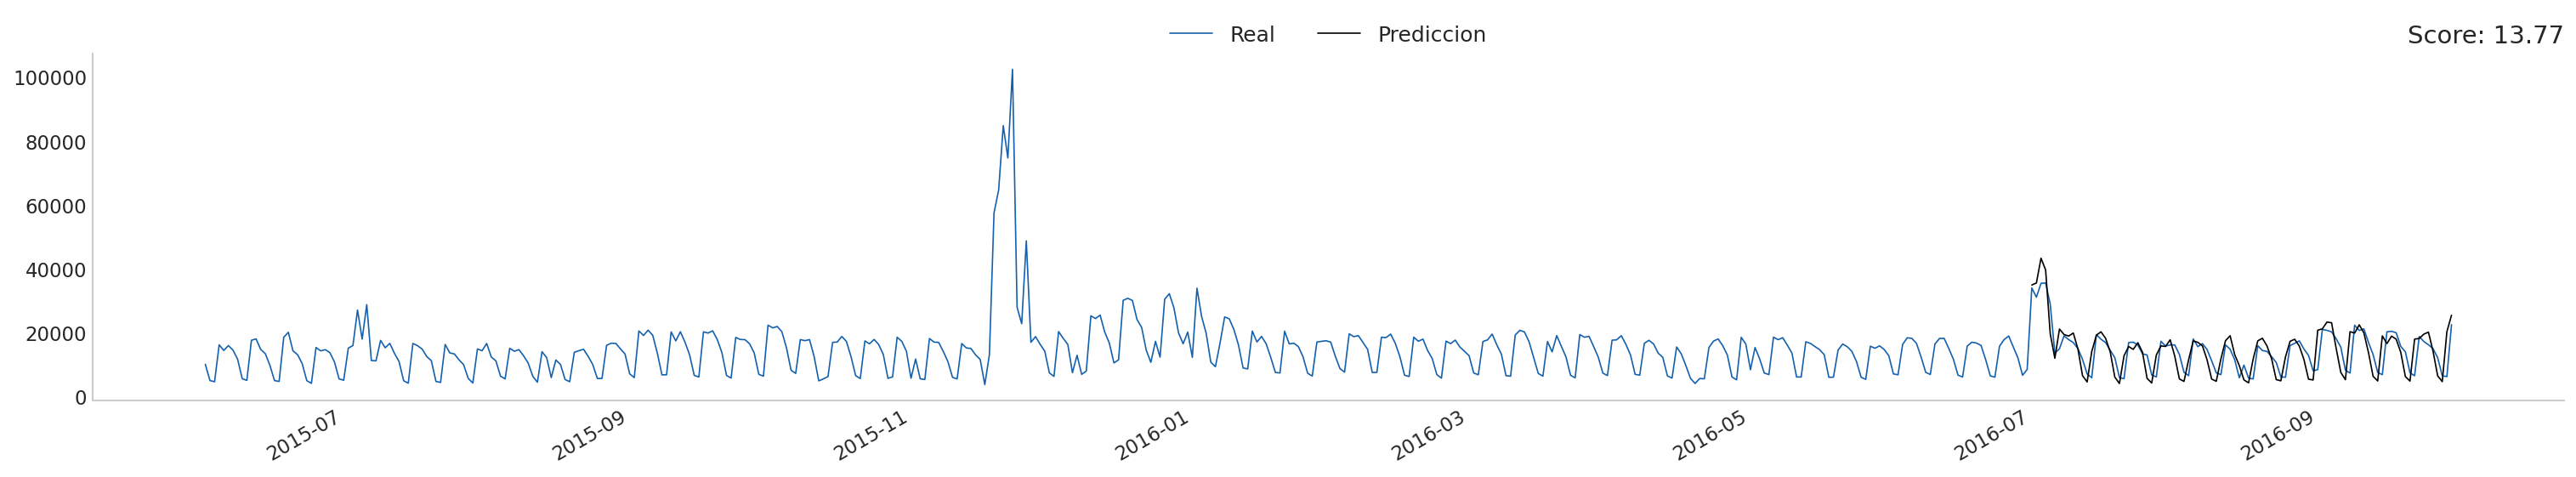

In [ ]:
df['fecha'] = pd.to_datetime(df['fecha'], format='%Y/%m/%d')
df_te['fecha'] = pd.to_datetime(df_te['fecha'], format='%Y/%m/%d')
group1 = df.groupby(['fecha']).sum().sort_index()
group2 = df_te.groupby(['fecha']).sum().sort_index()


fig, ax = plt.subplots(figsize=(25,4))


_ = group1.plot(ax=ax,  y='unidades_vendidas', lw=.8)
_ = group2.plot(ax=ax, y='prediction', lw=.8)

ax.set_title('Score: {:.2f}'.format(rsme(df_te['unidades_vendidas'], df_te['prediction'])), loc='right')


ax.legend(
    ['Real', 'Prediccion'],
    ncol=3,
    bbox_to_anchor=(0.5, 1.15),                   
    prop={'size': 12},
    frameon=False
)
_ = ax.set_xlabel('')

### Entrenando el modelo con el conjunto de entrenamiento completo y prediciendo el dataset de estimación:

In [ ]:
df_test = pd.read_csv('Estimar2.txt', sep='|', encoding='utf-8')
df_test['fecha'] = pd.to_datetime(df_test['fecha'], format='%Y/%m/%d')

D:\Anaconda3\envs\intro_python\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Sabiendo que el número de visitas es la variable que más correlación con las ventas tiene, podemos ver las visitas que hay en set de test para hacernos una idea de cómo deberian ser las predicciones de ventas. En este caso, lo que vemos es como durante el black friday las visitas se disparan con lo que deberíamos observar un comportamiento similar en cuanto a ventas, como se obserbó durante 2015

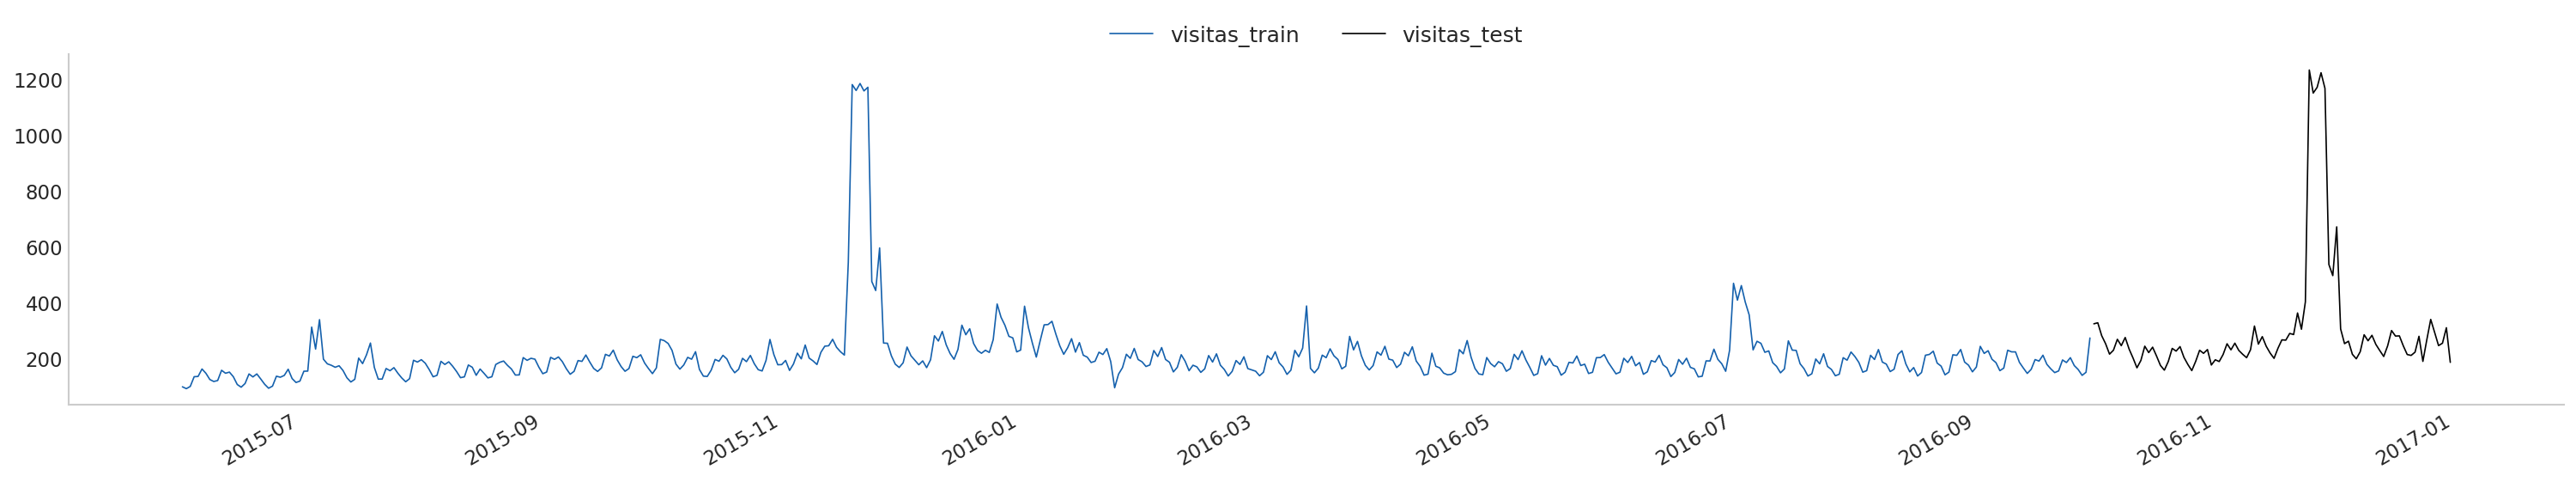

In [ ]:
group1 = df.groupby(['fecha']).mean().sort_index()
group2 = df_test.groupby(['fecha']).mean().sort_index()


fig, ax = plt.subplots(figsize=(25,4))
ax.set_yscale('linear')


_ = group1.plot(ax=ax,  y='visitas_normalized2', lw=.8)
_ = group2.plot(ax=ax, y='visitas', lw=.8)


ax.legend(
    ['visitas_train', 'visitas_test'],
    ncol=3,
    bbox_to_anchor=(0.5, 1.15),
    prop={'size': 12},
    frameon=False
)
_ = ax.set_xlabel('')

Necesitamos aplicar dos cambios para adaptar el test set al modelo de predicción:
- Como el orden de magnitud de las visitas del test es el que vemos en el conjunto de entrenamiento a partir de 2016, simplemente renombraremos la columna 'visitas' por 'visitas_normalized'
- Necesitamos imputar el conversion rate de los 'ids' a los productos que aparecen en el conjunto de test
- Necesitamos tener el día de la semana y el mes en sendas columnas del dataframe de test
- Debemos convertir el precio a float cambiando la coma decimal por un punto

In [ ]:
df_test = df_test.rename(columns={'visitas': 'visitas_normalized2'}, inplace=False)

In [ ]:
df_test = pd.merge(df_test, df[['id','categoria_uno_trend']].drop_duplicates(), on='id', how='left')
df_test

,fecha,id,visitas_normalized2,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,categoria_uno_trend
0,2016-10-01,21972,5,C,75,No Rotura,"5,84",0,0,5150,9634.428329
1,2016-10-01,21972,5,C,75,No Rotura,"5,84",0,0,5150,9712.105125
2,2016-10-01,21972,5,C,75,No Rotura,"5,84",0,0,5150,9777.879831
3,2016-10-01,21972,5,C,75,No Rotura,"5,84",0,0,5150,9942.629808
4,2016-10-01,21972,5,C,75,No Rotura,"5,84",0,0,5150,10085.454883
...,...,...,...,...,...,...,...,...,...,...,...
102549337,2016-12-30,458660,1225,K,340,No Rotura,"70,85",1,0,35,111622.857143
102549338,2016-12-30,458660,1225,K,340,No Rotura,"70,85",1,0,35,126252.857143
102549339,2016-12-30,458660,1225,K,340,No Rotura,"70,85",1,0,35,134244.285714
102549340,2016-12-30,458660,1225,K,340,No Rotura,"70,85",1,0,35,140085.714286


In [ ]:
df_test['month'] = df_test['fecha'].dt.month
df_test['day_of_week'] = df_test['fecha'].dt.dayofweek

In [ ]:
df_test['precio'] = df_test['precio'].str.replace(',', '.')

##### Entrenar los modelos Ridge para todo el conjunto de entrenamiento:

In [ ]:
groupby_cols = ['month','day_of_week','categoria_uno']
indep_cols = ['visitas_normalized2', 'dia_atipico', 'campaña', 'precio', 'categoria_uno_trend']
df_ridge_train = df.groupby(groupby_cols).apply(ridge_reg, indep_vars = indep_cols)
data_ridge_train = pd.DataFrame(df_ridge_train,columns=['Reg_Coef_and_Scaler'])
data_ridge_train

Reg_Coef_and_Scaler
month day_of_week categoria_uno                                                   
1     0           A              ((4.138528138528138, [3.9808328771308252, 0.29...
                  B              ((2.7877358490566033, [3.2919773250475473, 0.2...
                  C              ((4.765625, [3.280154386650232, 0.051096189796...
                  D              ((0.0, [0.0, 0.0, 0.0, 0.0, 0.0]), StandardSca...
                  E              ((2.927051671732523, [9.70853011003926, 0.7826...
...                                                                            ...
12    6           I              ((7.1, [8.50433265808987, 1.987886031157392, 0...
                  K              ((6.243521341463415, [20.395054747319474, 0.55...
                  L              ((7.9197247706422, [20.631604307709267, 1.3131...
                  N              ((2.500000000000003, [4.0322273914229, 0.47669...
                  O              ((6.000000000000001, [4.419595277539941, 2.026...

[1092 rows x 1 columns]

##### Estimar los valores de unidades vendidas en el set de test:

In [ ]:
demand_hat_2 = []
for i in range(df_test.shape[0]):
    demand_hat_2.append(predict(df_test.iloc[i], groupby_cols, data_ridge, indep_cols))
df_test['prediction'] = demand_hat_2

##### Observar como queda la línea temporal uniendo las ventas reales del conjunto de entrenamiento con las predicciones en el conjunto de test:

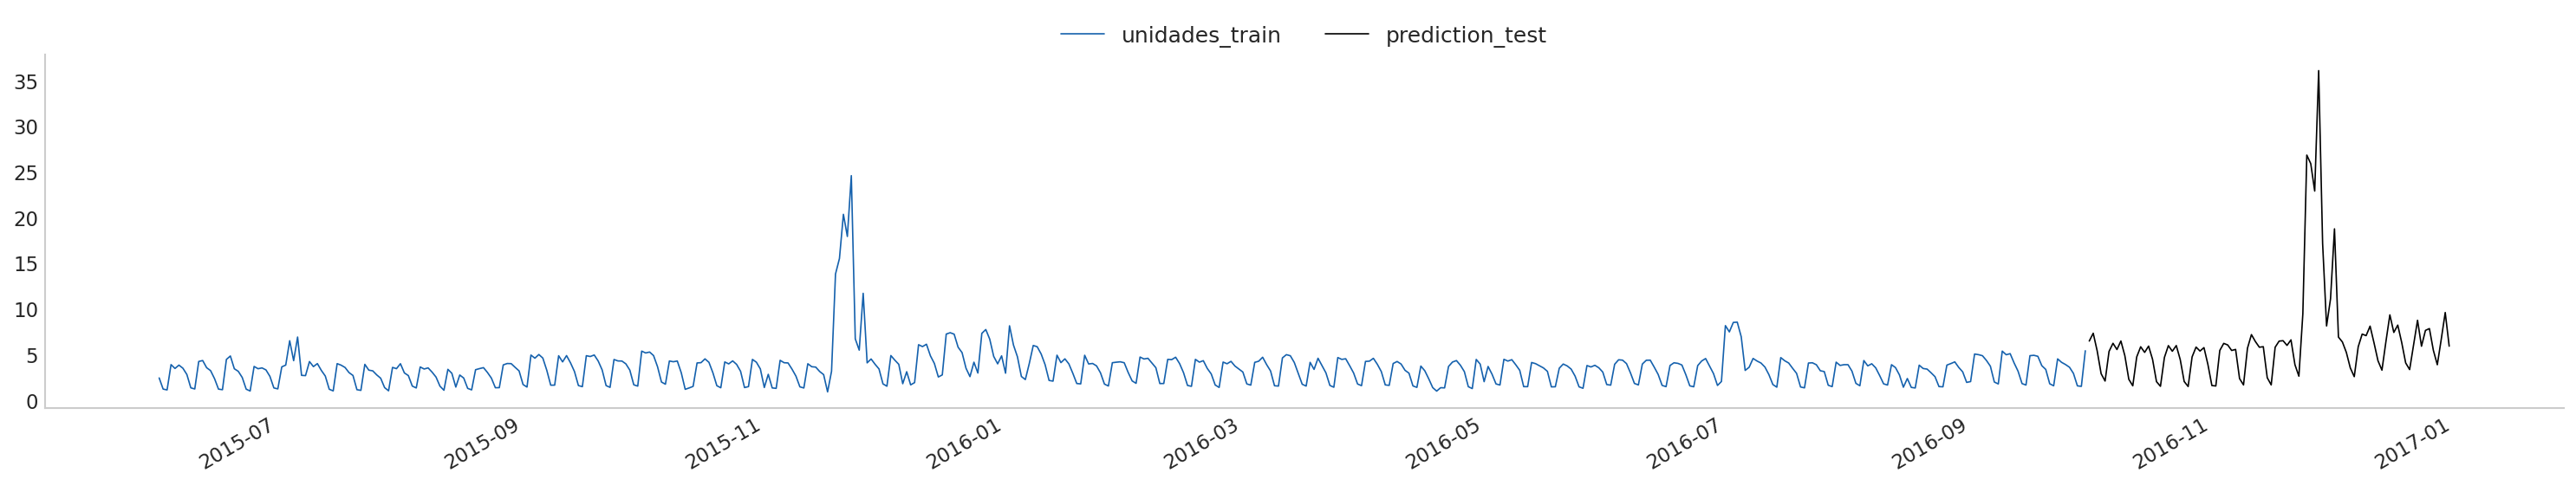

In [ ]:
group1 = df.groupby(['fecha']).mean().sort_index()
group2 = df_test.groupby(['fecha']).mean().sort_index()


fig, ax = plt.subplots(figsize=(25,4))
ax.set_yscale('linear')


_ = group1.plot(ax=ax,  y='unidades_vendidas', lw=.8)
_ = group2.plot(ax=ax, y='prediction', lw=.8)


ax.legend(
    ['unidades_train', 'prediction_test'],
    ncol=3,
    bbox_to_anchor=(0.5, 1.15),
    prop={'size': 12},
    frameon=False
)
_ = ax.set_xlabel('')

### Conclusiones:
- La metodologia de aplicar diversas regresiones lineales para agrupaciones de registros en funcion de variables categóricas es lo suficientemente buena como para establecer un baseline comparativo con otros modelos que vamos a utilizar, pues consigue captar la naturaleza estacional en función del mes y del día de la semana, así como picos puntuales de ventas en momentos atípicos como la semana del black friday
- Sin embargo, vamos a desestimar este modelo de cara a hacer la predicción final por varios motivos: Los valores de venta que nos predice son superiores para los mismos periodos del año anterior y la métrica para valorar la bondad del modelo es notablemente más elevada que la de otros modelos testados